<a href="https://colab.research.google.com/github/jamslaugh/tacotron2_thesis/blob/main/NLP_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Links and Intro:

Questo Notebook presenta differenti approcci mutuati dalle attuali architetture di maggior successo per creare un chatbot.

Gli approcci proposti riguardano due possibili strade: una tramite un modello tradizionale di Machine Learning, ancora da implementare, ed un altro basato su tecniche di Deep Learning.

- Fine Tuning Approach (keras [tutorial](https://keras.io/examples/nlp/text_extraction_with_bert/)) 
- Transformer Architecture [here](https://www.tensorflow.org/tutorials/text/transformer)
- Bert [transfer learning](https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/)
- GPT3 [model](https://analyticsindiamag.com/gpt-3-vs-bert-for-nlp-tasks/#:~:text=%20GPT-3%20Vs%20BERT%20For%20NLP%20Tasks%20,BERT%20have%20been%20relatively%20new%20for...%20More%20), [paper](https://arxiv.org/pdf/2005.14165.pdf)
- TextVectorization [towards data science](https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee)

### Lo stato attuale:

Il modello creato è un ibrido tra un modello convolutivo ed un modello ricorrente. Il primo permette di catturare eventuali correlazioni tra varie parole, mentre il secondo permette di catturare la struttura delle frasi insierite.

Flusso da sviluppare:

- normalize sentence;
- Tokenize
- w2id
- id2w (lookup table)


Stato dei lavori: attualmente ho implementato, dopo varie strade percorse, una rete che riesce a trasformare i vocaboli in numeri, integers. Questa rete permette di generare l'input da dare in pasto alla rete neurale dopo.

La rete prende in input un dataset espresso come tensore monodirezionale. Quindi la rete avrà la seguente struttura:

```python
text_dataset = tf.data.Dataset.from_tensor_slices(["foo","ciao", "bar", "baz",...,'zagbria','<UNK>'])
```

Nel preprocessing, bisogna andare a considerare anche una serie di altri elementi, ovviamente. 

Importante è valutare se togliendo la punteggiatura o performando word stemmer è possibile o meno ottimizzare le prestazioni della rete.

### Steps:

1. Carica il dataset tramite csv su pandas
2. Tokenizza il dataset tramite keras o tramite stesso nltk (ques'ultimo funziona già bene)
3. Crea il vocabolario
4. Crea il dataset con l'istruzione di sopra, aggiungendo, però, al vocabolario (dato con `set([el for el in df.apply(word_tokenize)])`, o altro tokenizer)
5. Inizializza il 
```python
vectorize_layer = layers.experimental.preprocessing.\
TextVectorization(
max_tokens=max_features,
output_mode='int',
output_sequence_length=max_len)
```
6. Adatta il TextVectorization al dataset dei tuoi tokens, semplicemente facendo `vectorize_layer.adapt(text_dataset.batch(64))`
7. Creiamo il modello seguente:
```python
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
```
8. Alla fine, poi abbiamo: `model.predict(input_data)`

---

Nota: TextVectorization fa anche la parte di padding, oltre che di tokenization.

In [ ]:
!pip install trax
import trax as tl

     |████████████████████████████████| 629 kB 6.6 MB/s 
     |████████████████████████████████| 152 kB 71.1 MB/s 
     |████████████████████████████████| 4.4 MB 50.4 MB/s 
     |████████████████████████████████| 269 kB 69.8 MB/s 
     |████████████████████████████████| 90 kB 13.3 MB/s 
     |████████████████████████████████| 1.2 MB 53.8 MB/s 
     |████████████████████████████████| 366 kB 76.6 MB/s 
     |████████████████████████████████| 4.0 MB 50.7 MB/s 
     |████████████████████████████████| 2.8 MB 45.6 MB/s 
     |████████████████████████████████| 52 kB 2.0 MB/s 
     |████████████████████████████████| 895 kB 67.7 MB/s 
     |████████████████████████████████| 3.3 MB 70.8 MB/s 
     |████████████████████████████████| 636 kB 78.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import dot,Concatenate,Add, Average, AveragePooling1D,Input,LSTM,Bidirectional, Reshape,SpatialDropout1D, Dropout, Conv1D, GRU, MaxPool1D, Conv2D, TimeDistributed, MaxPool2D,Dense, ReLU, BatchNormalization, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping, History, LearningRateScheduler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import LogCosh, MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import re
import os
from nltk.tokenize import word_tokenize
import nltk
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import json
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Usecases

data1 = {
    "intents": [
        {
            "tag": "ciao",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                "hi",
                "good morning",
                "hello",
                "good evening",
                "good afternoon"
            ],
            "responses": [
                "<msg>How can I help you?</msg>"
            ],
            "context_set": "[[START_CHAT]]"
        },
        {
            "tag": "cambio_valore_programmazione_settimanale_MRP",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                "can you change the weekly MRP schedule?",
                "Is is possible to change the weekly MRP schedule?",
                "Change the weekly MRP schedule",
                "Please, change the weekly MRP schedule",
                "I'd like to change the weekly MRP schedule",
                "MRP schedule change",
                "change MRP schedule for the next week",
                "change MRP schedule for the next month"
            ],
            "responses": [
                "<msg>Please choose the Plant on which you want to set it:</msg><att><br/><ul><li><a href='#' onclick=callBot('[TAG]programmazione_settimanale_MRP')>AGAP - Maserati</a></li><li><a href='#' onclick=callBot('[TAG]programmazione_settimanale_MRP')>Cassino</a></li><li><a href='#' onclick=callBot('[TAG]programmazione_settimanale_MRP')>Kragujevac - Serbia</a></li><li><a href='#' onclick=callBot('[TAG]programmazione_settimanale_MRP')>Maserati Modena</a></li><li><a href='#' onclick=callBot('[TAG]programmazione_settimanale_MRP')>Melfi - SATA</a></li><li><a href='#' onclick=callBot('[TAG]programmazione_settimanale_MRP')>Mirafiori</a></li><li><a href='#' onclick=callBot('[TAG]programmazione_settimanale_MRP')>Rajangaon - India</a></li><li><a href='#' onclick=callBot('[TAG]programmazione_settimanale_MRP')>Val Di Sangro - SEVEL Sud</a></li><li><a href='#' onclick=callBot('[TAG]programmazione_settimanale_MRP')>Vico</a></li></ul></att>"
            ],
            "context_set": "[[START_CHAT]]"
        },
        {
            "tag": "programmazione_settimanale_MRP",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                         "Show me the last week MRP schedule",
                         "What is the last week MRP schedule?",
                         "last week MRP schedule",
                         "I would see last week MRP schedule",
                         "Can you show me the last week MRP schedule?",
                         "give me the last week MRP schedule.",
                         "give me the last week MRP schedule!"
                         ],
            "responses": [
                "<msg>please choose a value</msg>"
            ],
            "context_set": "programmazione_settimanale_MRP"
        },
        {
            "tag": "cosa_approvare",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                "can you show me what is in pending approval on DRIVE-IT?",
                "show me what is in pending approval on DRIVE-IT",
                "can you show me what is in pending approval?",
                "can we see what is pending approval on DRIVE-IT?",
                "can I see what is pending approval on DRIVE-IT?",
                "Pending approvals on DRIVE-IT?"
            ],
            "responses": [
                "<msg>The following are all the processes for which an approval is still needed:</msg><att><ul class='list-group'><li class='list-group-item customListHeader'>ENHANCEMENTS</li><li class='list-group-item customListItem'>ENHC0145088</li><li class='list-group-item customListItem'>CHG0439969</li><li class='list-group-item customListItem'>CHG0439979</li><li class='list-group-item customListItem'>ENHC0145085</li></ul></att>"
            ],
            "context_set": "[[START_CHAT]]"
        },
        {
            "tag": "enhancement_ultimo_mese",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                "Can you show me the last month ticket distribution on OSS?",
                "Can you show me the last month OSS ticket distribution?",
                "OSS ticket distribution",
                "What is the last month OSS ticket distribution?",
                "I need OSS ticket distribution",
                "which is the OSS ticket distribution?"
            ],
            "responses": [
                "<msg>Here you are:</msg><att><div class='messageAtt'><div class='row'><a class='imagePopup' href='./images/assets/fca/grafico2.png'><img src='./images/assets/fca/grafico2.png' style='max-width: 60%;'></a></div></div></att>"
            ],
            "context_set": "[[START_CHAT]]"
        },
        {
            "tag": "ciao",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                "hi",
                "good morning",
                "hello",
                "good evening",
                "good afternoon"
            ],
            "responses": [
                "<msg>How can I help you?</msg>"
            ],
            "context_set": "[[START_CHAT]]"
        },
        {
            "tag": "subPKOSS_1",
            "context_label": "Create a new SubPK on OSS",
            "patterns": [
                "how can I create a new SubPK on OSS?",
                "Create a new SubPK on OSS",
                "I want to create a new SubPK on OSS",
                "I'd like to create a new SubPK on OSS",
                "how to create new SubPK on OSS"
            ],
            "responses": [
                "<msg>From CDM access to the 'Sub PK Maintenance' menu</msg> <att><div class='messageAtt'><div class='row'><a class='imagePopup' href='./images/assets/fca/wiz_step1.png'><img src='./images/assets/fca/wiz_step1.png' style='max-width: 60%;' alt='conf_01' ></a></div><div class='row containerButton'><div><br/><button class='btn btn-primary btn-sm' onclick=callBot('[TAG]subPKOSS_2')>Continue</button> <button class='btn btn-secondary btn-sm' onclick=callBot('[TAG]subPKOSS_exit')>Exit</button></div></div></div></att>"
            ],
            "context_set": "subPKOSS",
            "context_filter": [
                "[[START_CHAT]]"
            ]
        },
        {
            "tag": "MTM",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                "what is MTM?",
                "about MTM",
                "tell me about MTM",
                "I want to know MTM",
                "Just tell me MTM",
                "I'd like to know MTM",
                "What can you tell me about MTM?",
                "want MTM",
                "real MTM",
                "MTM definition",
                "How to MTM",
                "know MTM"
                "MTM",
                "definition of MTM"
            ],
            "responses": [
                "<msg>Market Target Maintenance is the UI that manages market's requests.</msg>"
            ],
            "context_set": "[[START_CHAT]]"
        },
        {
            "tag": "anticipo_OSS",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                "what is an OSS advance?",
                "define OSS advance",
                "tell me about OSS advance",
                "I want to know OSS advance",
                "OSS advance?",
                "what OSS advance?"
            ],
            "responses": [
                "<msg>It is the activity that is carried out by the Supply Chain when an order for which it is responsible is moved (anticipated) in the hands of the Factory.</msg>"
            ],
            "context_set": "[[START_CHAT]]"
        },
        {
            "tag": "ordini_su_OSS",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                "who manages orders made via OSS?",
                "I want to know who manages orders made via OSS",
                "tell me OSS orders manager"
            ],
            "responses": [
                "<msg>Orders on OSS are managed by Supply Chain or by the plant according to the horizon in which they are planned.</msg><att><br/>We can have:<ul><li>WSL: Order in Supply Chain Management</li><li>DSL: Order under management at the plant</li><li>POP: Order under management at the plant</li><li>GIR: Order present on the production line of the factory</li><li>DIF: Order that has been produced</li><li>ASF: Order that has been assigned</li></ul></att>"
            ],
            "context_set": "[[START_CHAT]]"
        },
        {
            "tag": "report_MTM",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                "can you show me MTM reports?",
                "show me MTM reports",
                "I'd like to know MTM reports",
                "What is MTM reports",
                "What are MTM reports",
                "I want to know MTM reports"
            ],
            "responses": [
                "<msg>Please, select which one you want to read:</msg><att><ul class='list-group'><li class='list-group-item customListHeader'>REPORTS</li><li class='list-group-item customListItem'><a target='_blank' href='doc_repository/documenti/fca/EMEA_MTM_Veloce_MKT_solo_dettaglio_MESE_Backlog.xlsx'>EMEA_MTM_Veloce_MKT_solo_dettaglio_MESE_Backlog</a></li><li class='list-group-item customListItem'><a href='doc_repository/documenti/fca/MTM_Veloce_Torrini_LEAD_TIME_OCF_220_giorni.xlsx' target='_blank'>MTM_Veloce_Torrini_LEAD_TIME_OCF_220_giorni</a></li></ul></att>"
            ],
            "context_set": "[[START_CHAT]]"
        },
        {
            "tag": "guide_MTM",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                "can you show me the MTM guidelines?",
                "What are the MTM guidelines?",
                "show me the MTM guidelines",
                "I'd like to know MTM guidelines",
                "show MTM guidelines",
                "tell me the MTM guidelines",
                "MTM guidelines",
                "MTM guidelines info",
                "about MTM guidelines"
            ],
            "responses": [
                "<msg>I have retrieved the available guides:</msg><att><ul class='list-group'><li class='list-group-item customListHeader'>GUIDE</li><li class='list-group-item customListItem'><a target='_blank' href='doc_repository/documenti/fca/MTM_Training.pptx'>MTM Training</a></li><li class='list-group-item customListItem'><a href='doc_repository/documenti/fca/OSS_Bulletin_024_OSS_MTM_nuove_funzionalita.pptx' target='_blank'>OSS Bulletin 024 OSS MTM nuove funzionalita'</a></li><li class='list-group-item customListItem'><a href='doc_repository/documenti/fca/OSS_Bulletin_031_OSS_MTM_CM_nuovi_campi.pptx' target='_blank'>OSS Bulletin 031 OSS MTM CM nuovi campi</a></li></ul></att>"
            ],
            "context_set": "[[START_CHAT]]"
        },
        {
            "tag": "apertura_ticket",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                "I would like OSS team support",
                "OSS team support",
                "Open a ticket on OSS",
                "I would like to open a ticket on OSS",
                "Need to open a ticket on OSS",
                "OSS open ticket",
                "How can I open a ticket on OSS?",
                "team OSS support",
                "OSS support team",
                "open a ticket on OSS"
            ],
            "responses": [
                "<msg>Ok. What's the issue?</msg>"
            ],
            "context_set": "ticket",
            "context_filter": [
                "[[START_CHAT]]"
            ]
        },
        {
            "tag": "apertura_ticket_modale",
            "context_label": "Open ticket",
            "patterns": [
                "Melfi 2021 roof towers completely empty for all models",
                "Melfi 2021 roof towers are completely empty",
                "Roof towers completely empty for all models for 2021"
                
            ],
            "responses": [
                "<msg>Ok. To proceed with the opening of the ticket it is possible to use the key shown below.<br/>Fields will already be pre-populated (albeit modifiable if needed).</msg><att><div class='row containerButton'><div class='col-12'><att><button class='btn btn-success btn-sm' onclick=\"$('#ticketModalFca').modal('show')\">Open ticket modal</button></att></div></div></att>"
            ],
            "context_set": "[[START_CHAT]]",
            "context_filter": [
                "ticket"
            ]
        },
        {
            "tag": "programmazione settimanale MRP",
            "context_label": "[[START_CHAT]]",
            "patterns": [
                "can you change the weekly MRP schedule?",
                "I want to change MRP weekly schedule",
                "change MRP weekly schedule",
                "please change MRP weekly schedule"
            ],
            "responses": [
                "<msg>If you intend to perform such operation it is necessary to authenticate yourself.</msg><att><br/><br/><button class='btn btn-primary btn-sm' onclick=\"$('#loginLink').click()\">Login</button></att>"
            ],
            "context_set": "[[START_CHAT]]"
        }
    ]
}

data_all = pd.DataFrame(data1['intents'])
#data2 = pd.DataFrame(data2['intents'])

In [ ]:
data_all.head()

,tag,context_label,patterns,responses,context_set,context_filter
0,ciao,[[START_CHAT]],"[hi, good morning, hello, good evening, good a...",[<msg>How can I help you?</msg>],[[START_CHAT]],NaN
1,cambio_valore_programmazione_settimanale_MRP,[[START_CHAT]],"[can you change the weekly MRP schedule?, Is i...",[<msg>Please choose the Plant on which you wan...,[[START_CHAT]],NaN
2,programmazione_settimanale_MRP,[[START_CHAT]],"[Show me the last week MRP schedule, What is t...",[<msg>please choose a value</msg>],programmazione_settimanale_MRP,NaN
3,cosa_approvare,[[START_CHAT]],[can you show me what is in pending approval o...,[<msg>The following are all the processes for ...,[[START_CHAT]],NaN
4,enhancement_ultimo_mese,[[START_CHAT]],[Can you show me the last month ticket distrib...,[<msg>Here you are:</msg><att><div class='mess...,[[START_CHAT]],NaN


In [ ]:
!cp ./data_all.json /content/drive/My\ Drive/indra_challenge/

cp: cannot stat './data_all.json': No such file or directory


In [ ]:
!cp -r /content/drive/My\ Drive/indra_challenge ./

cp: cannot open '/content/drive/My Drive/indra_challenge/train_dataset_intent.gsheet' for reading: Operation not supported


In [ ]:
train = pd.read_csv('./indra_challenge/train_dataset_intent.csv',sep=';')
test_label = pd.read_csv('./indra_challenge/test_dataset_intent_to_share_labels.csv')
test_intent = pd.read_csv('./indra_challenge/test_dataset_intent_to_share.csv')
train.head()

,question,scenario,intent
0,have i got any alarms set,alarm,query
1,what's the current temperature,weather,query
2,tell me about lisa ann,qa,factoid
3,play jumper by third eye blind,play,music
4,if there any alarm is set then let me know,alarm,query


In [ ]:
train.to_excel("/content/drive/My Drive/indra_challenge/train_dataset.xlsx")

In [ ]:
wt = train.question.apply(word_tokenize)
wt

0                         [have, i, got, any, alarms, set]
1                    [what, 's, the, current, temperature]
2                             [tell, me, about, lisa, ann]
3                    [play, jumper, by, third, eye, blind]
4        [if, there, any, alarm, is, set, then, let, me...
                               ...                        
14509                    [i, want, to, mute, the, speaker]
14510      [are, there, any, alarms, set, what, are, they]
14511               [put, on, some, techno, music, please]
14512                    [kill, all, the, frogs, you, see]
14513            [can, you, shut, off, my, bedroom, light]
Name: question, Length: 14514, dtype: object

# Deep Learning Approach

## This can be skipped

In [ ]:
#@title TPU support, fix later
#print("Tensorflow version " + tf.__version__)

#try:
#  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#except ValueError:
#  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
#
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
#@title VectorizationLayer class - works but need to wait.
# class VectorizationLayer(layers.experimental.preprocessing.PreprocessingLayer):
    
#     def __init__(self,vocabulary=None,depth=None,minimum=None,standardize=None,output_mode='int',max_features=6554,max_len=51):
#         super().__init__()
#         self.vectorize_layer = layers.experimental.preprocessing.TextVectorization(
#                                                             max_tokens=max_features,
#                                                             output_sequence_length=max_len,
#                                                             standardize=standardize,
#                                                             output_mode=output_mode)
#         if vocabulary:
#             self.vectorize_layer.set_vocabulary(vocabulary)
#         self.depth = depth
#         self.minimum = minimum
#         self.vocab = self.vectorize_layer.get_vocabulary()

#     def adapt(self, data):
#         try:
#             assert type(text_dataset) == tf.python.data.ops.dataset_ops.TensorSliceDataset
#         except:
#             raise TypeError('Invalid data format, expected tensorflow.python.data.ops.dataset_ops.TensorSliceDataset received %s'%(type(text_dataset)))
#         self.vectorize_layer.adapt(data.batch(64))
#         vocab = self.vectorize_layer.get_vocabulary()
#         self.depth = len(vocab)
#         indices = [i[0] for i in self.vectorize_layer([[v] for v in vocab]).numpy()]
#         self.minimum = min(indices)
    
#     def call(self,inputs):
#         vectorized_layer = self.vectorize_layer.call(inputs)
#         return vectorized_layer


In [ ]:
#raw = [[re.sub('\s{2,}', ' ', re.sub('([\[.,!?()\'\]])', r' \1 ', el)).lower()] for el in train['question'].to_list()]

In [ ]:
#vect = VectorizationLayer()
#vect.adapt(tf.data.Dataset.from_tensor_slices(list(set([k for el in raw for k in el[0].split()]))))
#vect.call(input_data)

In [ ]:
#type(text_dataset) == tf.python.data.ops.dataset_ops.TensorSliceDataset

In [ ]:
# text_dataset = tf.data.Dataset.from_tensor_slices(list(set([k for el in raw for k in el[0].split()])))
# max_features = len(set([k for el in raw for k in el[0].split()]))  # Maximum vocab size.
# max_len = max([len(el[0].split()) for el in raw])  # Sequence length to pad the outputs to.
# #embedding_dims = 2

# # Create the layer.
# vectorize_layer = layers.experimental.preprocessing.TextVectorization(
#  max_tokens=max_features,
#  output_mode='int',
#  output_sequence_length=max_len,
#  standardize=None) #standardize none funziona!

# # Now that the vocab layer has been created, call `adapt` on the text-only
# # dataset to create the vocabulary. You don't have to batch, but for large
# # datasets this means we're not keeping spare copies of the dataset.
# vectorize_layer.adapt(text_dataset.batch(64)) #alternativamente vectorize_layer.adapt(text_dataset)

# # Create the model that uses the vectorize text layer
# model = tf.keras.models.Sequential()

# # Start by creating an explicit input layer. It needs to have a shape of
# # (1,) (because we need to guarantee that there is exactly one string
# # input per batch), and the dtype needs to be 'string'.
# model.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# # The first layer in our model is the vectorization layer. After this
# # layer, we have a tensor of shape (batch_size, max_len) containing vocab
# # indices.
# model.add(vectorize_layer)
# #model.add(Embedding(max_features,max_len))

# # Now, the model can map strings to integers, and you can add an embedding
# # layer to map these integers to learned embeddings.
# input_data = raw
# model.predict(input_data)



In [ ]:
def preprocessing_pipeline(train,text_col = 'question'):
    import re
    train[text_col] = train[text_col]
    train[text_col] = train[text_col].str.lower().apply(lambda x: \
                                                                      re.sub('\s{2,}', ' ', re.sub('([.,!?()\'])', r' \1 ', x)))
    data = train[text_col].str.lower().apply(word_tokenize)
    vocabulary = set([el for k in data for el in k ])
    voc_len = len(vocabulary)
    oh_data = train.question.apply(one_hot,args=[len(vocabulary)])
    pad_max_len=np.array([len(el) for el in data]).max()
    sequences = pad_sequences(oh_data.to_list(),pad_max_len,padding = 'post')
    
    y = pd.get_dummies(train[['scenario','intent']],prefix=['scen','int'])
    x_train,x_test,y_train,y_test = train_test_split(sequences,y,stratify=y,test_size=0.1)
    y_train_scen = y_train[[el for el in y_train.columns if re.match('scen',el)]]
    y_train_int = y_train[[el for el in y_train.columns if re.match('int',el)]]
    y_train = [y_train_int,y_train_scen]
    y_test_scen = y_test[[el for el in y_test.columns if re.match('scen',el)]]
    y_test_int = y_test[[el for el in y_test.columns if re.match('int',el)]]
    y_test = [y_test_int,y_test_scen]
    output = {'sequences':sequences,
              'train_set':[x_train,y_train],
              'test_set':[x_test,y_test],
             'pad_max_len':pad_max_len,
             'voc_len':voc_len,
             'oh_data':oh_data,
             'vocabulary':vocabulary}
    return output

In [ ]:
def preprocessing_pipeline(train,text_col = 'question'):
    import re
    train[text_col] = train[text_col]
    
    raw = [[re.sub('\s{2,}', ' ', re.sub('([\[.,!?()\'\]])', r' \1 ', el)).lower()] for el in train[text_col].to_list()]
    vocabulary = list(set([k for el in raw for k in el[0].split()]))
    voc_len = len(vocabulary)
    oh_data = train.question.apply(one_hot,args=[len(vocabulary)])
    pad_max_len=max([len(el[0].split()) for el in raw])
    sequences = raw
    
    y = pd.get_dummies(train[['scenario','intent']],prefix=['scen','int'])
    x_train,x_test,y_train,y_test = train_test_split(sequences,y,stratify=y,test_size=0.1)
    y_train_scen = y_train[[el for el in y_train.columns if re.match('scen',el)]]
    y_train_int = y_train[[el for el in y_train.columns if re.match('int',el)]]
    y_train = [y_train_int,y_train_scen]
    y_test_scen = y_test[[el for el in y_test.columns if re.match('scen',el)]]
    y_test_int = y_test[[el for el in y_test.columns if re.match('int',el)]]
    y_test = [y_test_int,y_test_scen]
    output = {'train_set':[x_train,y_train],
              'test_set':[x_test,y_test],
             'pad_max_len':pad_max_len,
             'voc_len':voc_len,
             'vocabulary':vocabulary}
    return output

In [ ]:
trial = preprocessing_pipeline(train)

In [ ]:
y = pd.get_dummies(train[['scenario','intent']],prefix=['scen','int'])

In [ ]:
data = train.question.apply(word_tokenize)

In [ ]:
vocabulary = set([el for k in data for el in k ])

In [ ]:
len(vocabulary)

6586

In [ ]:
oh_data = train.question.apply(one_hot,args=[len(vocabulary)])

In [ ]:
oh_data

0                      [910, 5521, 3548, 4342, 2158, 2355]
1                                 [1912, 5386, 3833, 4675]
2                           [1116, 1164, 6088, 1771, 4662]
3                      [5859, 4816, 1775, 179, 3238, 3057]
4        [1277, 1906, 4342, 3742, 6087, 2355, 5961, 657...
                               ...                        
14509                   [5521, 902, 247, 2683, 5386, 1845]
14510     [2615, 1906, 4342, 2158, 2355, 6053, 2615, 1606]
14511                  [1775, 5518, 117, 6530, 3098, 1291]
14512                  [552, 2193, 5386, 1430, 2515, 2324]
14513              [2169, 2515, 5024, 927, 5312, 105, 169]
Name: question, Length: 14514, dtype: object

In [ ]:
pad_max_len=np.array([len(el) for el in data]).max()

In [ ]:
sequences = pad_sequences(oh_data.to_list(),pad_max_len,padding = 'post')

In [ ]:
sequences

array([[ 910, 5521, 3548, ...,    0,    0,    0],
       [1912, 5386, 3833, ...,    0,    0,    0],
       [1116, 1164, 6088, ...,    0,    0,    0],
       ...,
       [1775, 5518,  117, ...,    0,    0,    0],
       [ 552, 2193, 5386, ...,    0,    0,    0],
       [2169, 2515, 5024, ...,    0,    0,    0]], dtype=int32)

In [ ]:
target = pd.get_dummies(train.intent)

In [ ]:
#model.add(GRU(512,return_sequences=True,dropout=0.4))
#model.add(TimeDistributed(Dense(200, activation='sigmoid')))
#model.add(GRU(256,return_sequences=True,dropout=0.2))
#model.add(TimeDistributed(Dense(200, activation='sigmoid')))

### OLD ASKy

In [ ]:
#model_old = Sequential()
#model_old.add(Dense(180,input_shape=(49,),activation='relu'))
#model_old.add(Dense(60,activation='relu'))
#model_old.add(Dense(46,activation='softmax'))

In [ ]:
#model_old.compile(optimizer=Adam(learning_rate=0.001,decay=1e-8,beta_1=0.95,beta_2=0.999),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#model_old.fit(sequences,target,epochs=500,validation_split=0.05,batch_size = 512)

###New Asky

In [ ]:
def gru_layer(X_in,n_neurons=128,l1_reg = [0,0,0,0], l2_reg = [0.01,0.02,0.03,0.03],dropout = [0.4,0.4,0.6,0.6]):
    X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[0],l2=l2_reg[0]), dropout=dropout[0], return_sequences=True),name='gru_1')(X_in)
    #X = BatchNormalization()(X)
    X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[1],l2=l2_reg[1]), dropout=dropout[1], return_sequences=True),name='gru_2')(X)
    #X = BatchNormalization()(X)
    X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[2],l2=l2_reg[2]), dropout=dropout[2], return_sequences=True),name='gru_3')(X)
    #X = BatchNormalization()(X)
    X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[3],l2=l2_reg[3]), dropout=dropout[3], return_sequences=True),name='gru_4')(X)
    #X = BatchNormalization()(X)
    return X
def encoder_decoder(X_in,n_neurons=[256,64,256]):

    X = Dense(n_neurons[0],kernel_initializer='VarianceScaling',activation=None)(X_in)
    X = BatchNormalization()(X)
    X = ReLU()(X) 
    X = Dense(n_neurons[1],kernel_initializer='VarianceScaling',activation=None)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Dense(n_neurons[2],kernel_initializer='VarianceScaling',activation=None)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Dropout(0.4)(X)
    
    return X

def gru_head(X_in,n_classes,n_neurons = [128,64],dropout=[0.4,0.2],names='int'):
    
    X = Flatten()(X_in)
    X = Dense(n_neurons[0],activation=None)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    #X = Dropout(dropout[0])(X)
    #X = Dense(n_neurons[1],  'relu',name='last_stage_'+names)(X)
    X = Dropout(dropout[1])(X)
    X = Dense(n_classes, 'softmax',name='classification_layer_'+names)(X)
    return X

def gru_model(input_shape,voc_len,emb_neurons=128,n_classes=49): #old model
    X_input = Input(input_shape)
    X = Embedding(voc_len, emb_neurons, input_length=input_shape)(X_input)
    X1 = encoder_decoder(X)
    #X_gru = gru_layer(X)
    X_short = Embedding(voc_len, 256, input_length=input_shape)(X_input)
    X_short = Conv1D(256,7,padding='causal')(X_short)
    X_short = ReLU()(X_short)
    X_short = Conv1D(128,5,padding='causal')(X_short)
    X_short = ReLU()(X_short)
    X_short = Conv1D(64,3,padding='causal')(X_short)
    X_short = BatchNormalization()(X_short)
    X_short = ReLU()(X_short)
    #X = Add()([X,X_short])
    
    #X2 = encoder_decoder(X_gru)
    X3 = encoder_decoder(X_short)
    X4 = encoder_decoder(X1)
    X = Concatenate()([X3,X_short]) # to readd X1,X4,X2,
    X = Dropout(0.4)(X)
    X = gru_head(X,n_classes)

    return Model(inputs=X_input,outputs=X,name='gru_model')


In [ ]:
def gru_layer(X_in,n_neurons=128,l1_reg = [0,0,0,0], l2_reg = [0.01,0.02,0.03,0.03],dropout = [0.4,0.4,0.6,0.6]):
    X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[0],l2=l2_reg[0]), dropout=dropout[0], return_sequences=True),name='gru_1')(X_in)
    #X = BatchNormalization()(X)
    X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[1],l2=l2_reg[1]), dropout=dropout[1], return_sequences=True),name='gru_2')(X)
    #X = BatchNormalization()(X)
    X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[2],l2=l2_reg[2]), dropout=dropout[2], return_sequences=True),name='gru_3')(X)
    #X = BatchNormalization()(X)
    X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[3],l2=l2_reg[3]), dropout=dropout[3], return_sequences=True),name='gru_4')(X)
    #X = BatchNormalization()(X)
    return X
def encoder_decoder(X_in,n_neurons=[256,64,256]):

    X = Dense(n_neurons[0],kernel_initializer='VarianceScaling',activation=None)(X_in)
    X = BatchNormalization()(X)
    X = ReLU()(X) 
    X = Dense(n_neurons[1],kernel_initializer='VarianceScaling',activation=None)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Dense(n_neurons[2],kernel_initializer='VarianceScaling',activation=None)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Dropout(0.4)(X)
    
    return X

def gru_head(X_in,n_classes,n_neurons = [128,64],dropout=[0.4,0.2],names='int'):
    
    X = Flatten()(X_in)
    X = Dense(n_neurons[0],activation=None)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    #X = Dropout(dropout[0])(X)
    #X = Dense(n_neurons[1],  'relu',name='last_stage_'+names)(X)
    X = Dropout(dropout[1])(X)
    X = Dense(n_classes, 'softmax',name='classification_layer_'+names)(X)
    return X

def gru_model(vocab_data,voc_len,emb_neurons=128,n_classes=49): #old model
    vect = VectorizationLayer()
    vect.adapt(tf.data.Dataset.from_tensor_slices(list(set([k for el in vocab_data for k in el[0].split()]))))
    X_input = Input(input_shape=(1,),dtype=tf.string)
    X_input = vect.call(X_input)    
    X = Embedding(voc_len, emb_neurons, input_length=input_shape)(X_input)
    X1 = encoder_decoder(X)
    #X_gru = gru_layer(X)
    X_short = Embedding(voc_len, 256, input_length=input_shape)(X_input)
    X_short = Conv1D(64,3,padding='causal')(X_short)
    X_short = ReLU()(X_short)
    X_short = Conv1D(128,5,padding='causal')(X_short)
    X_short = ReLU()(X_short)
    X_short = Conv1D(256,7,padding='causal')(X_short)
    X_short = BatchNormalization()(X_short)
    X_short = ReLU()(X_short)
    #X = Add()([X,X_short])
    
    #X2 = encoder_decoder(X_gru)
    X3 = encoder_decoder(X_short)
    X4 = encoder_decoder(X1)
    X = Concatenate()([X3,X_short]) # to readd X1,X4,X2,
    X = Dropout(0.4)(X)
    X = gru_head(X,n_classes)

    return Model(inputs=X_input,outputs=X,name='gru_model')


In [ ]:
def gru_layer(X_in,n_neurons=128,l1_reg = [0,0,0,0], l2_reg = [0.01,0.02,0.03,0.03],dropout = [0.4,0.4,0.6,0.6]):
    X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[0],l2=l2_reg[0]), dropout=dropout[0], return_sequences=True),name='gru_1')(X_in)
    #X = BatchNormalization()(X)
    X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[1],l2=l2_reg[1]), dropout=dropout[1], return_sequences=True),name='gru_2')(X)
    #X = BatchNormalization()(X)
    X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[2],l2=l2_reg[2]), dropout=dropout[2], return_sequences=True),name='gru_3')(X)
    #X = BatchNormalization()(X)
    X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[3],l2=l2_reg[3]), dropout=dropout[3], return_sequences=True),name='gru_4')(X)
    #X = BatchNormalization()(X)
    return X
def encoder_decoder(X_in,n_neurons=[256,64,256]):

    X = Dense(n_neurons[0],kernel_initializer='VarianceScaling',activation=None)(X_in)
    X = BatchNormalization()(X)
    X = ReLU()(X) 
    X = Dense(n_neurons[1],kernel_initializer='VarianceScaling',activation=None)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Dense(n_neurons[2],kernel_initializer='VarianceScaling',activation=None)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Dropout(0.4)(X)
    
    return X

def gru_head(X_in,n_classes,n_neurons = [128,64],dropout=[0.4,0.2],names='int'):
    
    X = Flatten()(X_in)
    X = Dense(n_neurons[0],activation=None)(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    #X = Dropout(dropout[0])(X)
    #X = Dense(n_neurons[1],  'relu',name='last_stage_'+names)(X)
    X = Dropout(dropout[1])(X)
    X = Dense(n_classes, 'softmax',name='classification_layer_'+names)(X)
    return X

def gru_model(vocab_data,seq_len,voc_len,emb_neurons=128,n_classes=49): #old model
    X_input = Input((1,),dtype=tf.string)
    X = VectorizationLayer()
    X = Embedding(voc_len, emb_neurons, input_length=input_shape)(X_input)
    X1 = encoder_decoder(X)
    #X_gru = gru_layer(X)
    X_short = Embedding(voc_len, 256, input_length=input_shape)(X_input)
    X_short = Conv1D(256,7,padding='causal')(X_short)
    X_short = ReLU()(X_short)
    X_short = Conv1D(128,5,padding='causal')(X_short)
    X_short = ReLU()(X_short)
    X_short = Conv1D(64,3,padding='causal')(X_short)
    X_short = BatchNormalization()(X_short)
    X_short = ReLU()(X_short)
    #X = Add()([X,X_short])
    
    #X2 = encoder_decoder(X_gru)
    X3 = encoder_decoder(X_short)
    X4 = encoder_decoder(X1)
    X = Concatenate()([X3,X_short]) # to readd X1,X4,X2,
    X = Dropout(0.4)(X)
    X = gru_head(X,n_classes)

    return Model(inputs=X_input,outputs=X,name='gru_model')


In [ ]:
def gru_model_2(input_shape,voc_len,emb_neurons=128,n_classes_int=49,n_classes_scen=18):
    X_input = Input(input_shape)
    X = Embedding(voc_len, emb_neurons, input_length=input_shape)(X_input)
    #X1 = encoder_decoder(X)
    #X_gru = gru_layer(X)
    X_short = Embedding(voc_len, 256, input_length=input_shape)(X_input)
    X_short = Conv1D(64,5,padding='causal')(X_short)
    X_short = Conv1D(128,5,padding='causal')(X_short)
    X_short = Conv1D(256,5,padding='causal')(X_short)
    X = Add()([X,X_short])
    
    #X2 = encoder_decoder(X)
    #X3 = encoder_decoder(X_short)
    #X4 = encoder_decoder(X_input)
    #X = Concatenate()([X,X2,X3,X_short])
    X = Dropout(0.2)(X)
    X_intent = gru_head(X,n_classes_int,names='int')
    X_scenario = gru_head(X,n_classes_scen,names='scen')

    return Model(inputs=X_input,outputs=[X_intent,X_scenario],name='gru_model')

In [ ]:
def gru_model_3(input_shape,voc_len,emb_neurons=128,n_classes_int=46,n_classes_scen=18):
    X_input = Input(input_shape)
    K = Embedding(voc_len, emb_neurons)(X_input[1:])
    Q = Embedding(voc_len, emb_neurons)(X_input)
    X1 = encoder_decoder(X)
    X_gru = gru_layer(X)
    X_short = Embedding(voc_len, 256, input_length=input_shape)(X_input)
    #X_short = Conv1D(64,5,padding='causal')(X_short)
    #X_short = Conv1D(128,5,padding='causal')(X_short)
    #X_short = Conv1D(256,5,padding='causal')(X_short)
    #X = Add()([X,X_short])
    
    #X2 = encoder_decoder(X_gru)
    X3 = encoder_decoder(X_short)
    #X4 = encoder_decoder(X_input)
    X = Concatenate()([X1,X3,X_short])
    X = Dropout(0.2)(X)
    X_intent = gru_head(X,n_classes_int)
    X_scenario = gru_head(X,n_classes_scen)

    return Model(inputs=X_input,outputs=X,name='gru_model')

In [ ]:
target_scen = pd.get_dummies(train.scenario)
target.sum(axis=0)

addcontact           62
audiobook           167
cleaning            120
coffee              139
convert              68
createoradd         206
currency            265
definition          353
dislikeness          17
events              225
factoid             736
game                164
greet                17
hue_lightchange     157
hue_lightdim         88
hue_lightoff        172
hue_lighton          27
hue_lightup          99
joke                 85
likeness            143
locations           179
maths               113
movies               78
music               841
order               139
podcasts            265
post                379
query              4166
querycontact        155
quirky              740
radio               385
recipe              289
remove              689
sendemail           482
set                1213
settings             56
stock               189
taxi                129
ticket              167
traffic             140
volume_down          53
volume_mute     

In [ ]:
len(vocabulary)

6586

In [ ]:
def scheduler(epoch, lr):
    if lr < 0.0001:
        lr = 0.001
    if epoch < 20:
        return lr
    elif epoch < 100:
        return lr * tf.math.exp(-0.01)
    elif epoch < 150:
        return lr * tf.math.exp(-0.02)
    elif epoch < 250:
        return lr * tf.math.exp(-0.03)
    else:
        return lr*tf.math.exp(-0.04)


In [ ]:
np.arange(0,300)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

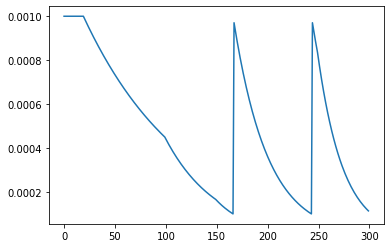

In [ ]:
import matplotlib.pyplot as plt
lr_data = []
epochs = np.arange(0,300)
lr = 0.001
for epoch in epochs:
    lr = scheduler(epoch,lr)
    lr_data.append(lr)
plt.plot(epochs,lr_data)

In [ ]:
# To be inserded: EarlyStopping(patience=10,min_delta=0.0001,restore_best_weights=True)
callb = [History(),EarlyStopping(patience=10,min_delta=0.0001,restore_best_weights=True),LearningRateScheduler(scheduler,verbose=True)]

model = gru_model_3(input_shape = sequences.shape[1],voc_len = len(vocabulary),n_classes_int=target.shape[1],n_classes_scen=target_scen.shape[1],emb_neurons=256)
model.compile(optimizer=Adam(learning_rate=0.001,decay=1e-10,beta_1=0.9955,beta_2=0.9995),loss='categorical_crossentropy',metrics=['accuracy'])
plot_model(model,show_shapes=True)

UnboundLocalError: ignored

In [ ]:
from google.colab import files
files.download('model.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Model Fit

train_data = model.fit(sequences,[target,target_scen],epochs=300,validation_split=0.1,batch_size = 512,callbacks=callb,use_multiprocessing=True)

Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
26/26 [==============================] - 11s 107ms/step - loss: 5.3478 - classification_layer_int_loss: 3.1190 - classification_layer_scen_loss: 2.2288 - classification_layer_int_accuracy: 0.2743 - classification_layer_scen_accuracy: 0.3546 - val_loss: 5.3088 - val_classification_layer_int_loss: 3.0411 - val_classification_layer_scen_loss: 2.2677 - val_classification_layer_int_accuracy: 0.5627 - val_classification_layer_scen_accuracy: 0.6591
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
26/26 [==============================] - 2s 64ms/step - loss: 2.2768 - classification_layer_int_loss: 1.4562 - classification_layer_scen_loss: 0.8206 - classification_layer_int_accuracy: 0.6446 - classification_layer_scen_accuracy: 0.7748 - val_loss: 3.7019 - val_classification_layer_int_loss: 2.2140 - val_classification_layer_scen_loss: 1.4879 - val_classif

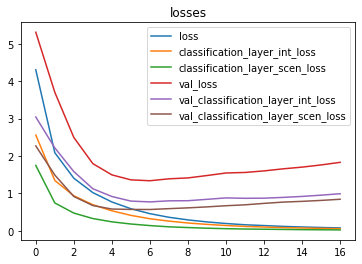

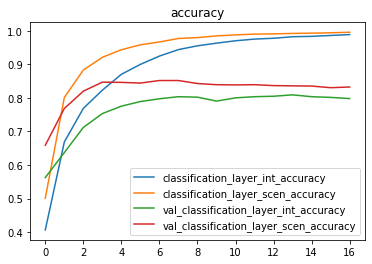

In [ ]:
#@title Dataframe creation and plotting
tr_df = pd.DataFrame(train_data.history)
tr_df[['loss','classification_layer_int_loss','classification_layer_scen_loss','val_loss','val_classification_layer_int_loss','val_classification_layer_scen_loss']].plot(title='losses')
tr_df[['classification_layer_int_accuracy','classification_layer_scen_accuracy','val_classification_layer_int_accuracy','val_classification_layer_scen_accuracy']].plot(title='accuracy')

In [ ]:
tf.math.exp(-12.0)

<tf.Tensor: shape=(), dtype=float32, numpy=6.1442124e-06>

## Class Trial

In [ ]:
#@title Old GRU Model
# class GruModel():

#     @staticmethod
#     def scheduler(epoch, lr):
#         if lr < 0.0001:
#             lr = 0.001
#         if epoch < 20:
#             return lr
#         elif epoch < 100:
#             return lr * tf.math.exp(-0.1)
#         elif epoch < 150:
#             return lr * tf.math.exp(-0.2)
#         elif epoch < 250:
#             return lr * tf.math.exp(-0.3)
#         else:
#             return lr*tf.math.exp(-0.4)
    
#     @staticmethod
#     def schedule_plotter(lr):
#         import matplotlib.pyplot as plt
#         lr_data = []
#         epochs = np.arange(0,300)
        
#         for epoch in epochs:
#             lr = scheduler(epoch,lr)
#             lr_data.append(lr)
#         plt.figure()
#         plt.plot(epochs,lr_data)
#         plt.title("Learning Rate Schedule Simulation")
#         plt.xlabel("Epochs")
#         plt.ylabel("Learning rate")
#         plt.show()
    
#     @classmethod
#     def preprocessor(cls,vocab_list,max_features,max_len):
#         text_dataset = tf.data.Dataset.from_tensor_slices(vocab_list)

#         # Create the layer.
#         vectorize_layer = layers.experimental.preprocessing.TextVectorization(
#         max_tokens=max_features,
#         output_mode='int',
#         output_sequence_length=max_len,
#         standardize=None) #standardize none funziona!

#         # Now that the vocab layer has been created, call `adapt` on the text-only
#         # dataset to create the vocabulary. You don't have to batch, but for large
#         # datasets this means we're not keeping spare copies of the dataset.
#         vectorize_layer.adapt(text_dataset.batch(64)) #alternativamente vectorize_layer.adapt(text_dataset)

#         # Create the model that uses the vectorize text layer
#         #model = tf.keras.models.Sequential()

#         # Start by creating an explicit input layer. It needs to have a shape of
#         # (1,) (because we need to guarantee that there is exactly one string
#         # input per batch), and the dtype needs to be 'string'.
#         X_in = tf.keras.Input(shape=(1,), dtype=tf.string)

#         # The first layer in our model is the vectorization layer. After this
#         # layer, we have a tensor of shape (batch_size, max_len) containing vocab
#         # indices.
#         X = vectorize_layer(X_in)
#         #model.add(Embedding(max_features,max_len))

#         # Now, the model can map strings to integers, and you can add an embedding
#         # layer to map these integers to learned embeddings.
#         return X
        

#     @classmethod
#     def gru_layer(cls,X_in, n_neurons=128, l1_reg=[0, 0, 0, 0], l2_reg=[0.01, 0.02, 0.03, 0.03],
#                   dropout=[0.4, 0.4, 0.6, 0.6]):
#         X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[0], l2=l2_reg[0]), dropout=dropout[0],
#                               return_sequences=True), name='gru_1')(X_in)
#         # X = BatchNormalization()(X)
#         X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[1], l2=l2_reg[1]), dropout=dropout[1],
#                               return_sequences=True), name='gru_2')(X)
#         # X = BatchNormalization()(X)
#         X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[2], l2=l2_reg[2]), dropout=dropout[2],
#                               return_sequences=True), name='gru_3')(X)
#         # X = BatchNormalization()(X)
#         X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[3], l2=l2_reg[3]), dropout=dropout[3]),
#                           name='gru_4')(X)
#         # X = BatchNormalization()(X)
#         return X
#     @classmethod
#     def encoder_decoder(cls,X_in, n_neurons=[256, 64, 256]):

#         X = Dense(n_neurons[0], kernel_initializer='VarianceScaling', activation=None)(X_in)
#         X = BatchNormalization()(X)
#         X = ReLU()(X)
#         X = Dense(n_neurons[1], kernel_initializer='VarianceScaling', activation=None)(X)
#         X = BatchNormalization()(X)
#         X = ReLU()(X)
#         X = Dense(n_neurons[2], kernel_initializer='VarianceScaling', activation=None)(X)
#         X = BatchNormalization()(X)
#         X = ReLU()(X)
#         X = Dropout(0.4)(X)

#         return X
#     @classmethod
#     def gru_head(cls,X_in, n_classes, n_neurons=[128, 64], dropout=[0.4, 0.2],name_custom = 'int'):

#         #X = Flatten()(X_in)
#         X = Dense(n_neurons[0], activation=None)(X)
#         X = BatchNormalization()(X)
#         X = ReLU()(X)
#         X = Dropout(dropout[0])(X)
#         X = Dense(n_neurons[1], 'relu', name='last_stage_'+name_custom)(X)
#         X = Dropout(dropout[1])(X)
#         X = Dense(n_classes, 'softmax', name='classification_layer_'+name_custom)(X)
#         return X
#     @classmethod
#     def gru_model(cls,input_shape, voc_len, emb_neurons=128, n_classes_int=49,n_classes_scen=19):
#         X_input = Input(input_shape)
#         X = Embedding(voc_len, emb_neurons, input_length=input_shape)(X_input)
#         X1 = encoder_decoder(X)
#         X_gru = gru_layer(X)
#         X_short = Embedding(voc_len, 256, input_length=input_shape)(X_input)
#         X_short = Conv1D(64,5,padding='causal',activation='relu')(X_short)
#         X_short = Conv1D(128,5,padding='causal',activation='relu')(X_short)
#         X_short = Conv1D(256,5,padding='causal',activation='relu')(X_short)
#         X = Concatenate()([X,X_short])
#         X = Dropout(0.6)(X) #last added
#         X2 = encoder_decoder(X_gru)
#         X3 = encoder_decoder(X_short)
#         #X4 = encoder_decoder(X_input)
#         X = Concatenate()([X,X1,X2,X3,X_short])
#         X = Dropout(0.6)(X) # last modified: dropout augmented to 0.6 from 0.2
#         X_intent = gru_head(X,n_classes_int,names='int')
#         X_scenario = gru_head(X,n_classes_scen,names='scen')

#         return Model(inputs=X_input,outputs=[X_intent,X_scenario],name='gru_model')

### skip that, fix later

Preprocessing:

- Tensorflow keras tokenizer (documentation)[https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer]

Model improvements:

- Attention models ([tf_tutorial](https://www.tensorflow.org/tutorials/text/nmt_with_attention))

- Transformer models ([tf_tutorial](https://www.tensorflow.org/tutorials/text/transformer))

- Transformer chatbot ([tf_tutorial](https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html))

In [ ]:
#class data_preprocess_alt():
#
#    def __init__(self,filename=None,text_col='question',json=False,sep=';'):
#        
#        if filename:
#            self.sep = sep
#            self.filename = filename
#            self.json = json
#
#            if json:
#                json_data = json.loads(self.filename)
#                self.train = pd.DataFrame(json_data)
#
#            else:
#
#                self.train = pd.read_csv(filename,sep=sep)
#        
#    
#    def normalize_sentence(self,sentence):
#        sentence = sentence.lower().strip()
#        
#        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
#        sentence = re.sub(r'[" "]+', " ", sentence)
#        
#        sentence = re.sub(r"[^a-zA-Z?.!,:]+", " ", sentence)
#        sentence = sentence.strip()
#
#        return sentence
#
#    def tokenize_sentence(self,corpus,tgt_vocab_size=6400):                                          # A tgt_vocab_size diamo un valore arbitrario, in realtà. Però da problemi così nell'embeddings...
#        tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(                            # Funziona sulle serie solo! Attenzione!
#                                                            corpus, target_vocab_size=tgt_vocab_size) 
#                                                        
#
#        # Definiamo start e fine di una frase
#        START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
#
#        # size del vocabolario, piu' token di inizio e fine.
#        VOCAB_SIZE = tokenizer.vocab_size + 2
#
#        return {'start_token':START_TOKEN,'end_token':END_TOKEN,'vocab_size':VOCAB_SIZE,'tokenizer':tokenizer}
#
#    def tokenize_and_filter(self,inputs,max_length=49,tgt_vocab_size=6400,tokenizer=None):
#        tokenized_inputs = []
#
#        if not tokenizer:
#            tokenize_Sentence = self.tokenize_sentence(inputs,tgt_vocab_size)
#            tokenizer = tokenize_Sentence['tokenizer']
#            START_TOKEN = tokenize_Sentence['start_token']
#            END_TOKEN = tokenize_Sentence['end_token']
#        else:
#            START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
#            
#        if not max_length:
#            print("max_len is: %d"%(np.array([len(el) for el in data]).max()))
#            MAX_LENGTH = np.array([len(el) for el in data]).max()# per avere max len devo prima ottenere la tokenization dei dati. Steps: 1) preprocess_sentence 2) 
#        else:
#            MAX_LENGTH = max_length
#        for sentence1 in inputs:
#            
#            sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
#            
#            
#            #if len(sentence1) <= MAX_LENGTH:
#            tokenized_inputs.append(sentence1) # da approfondire perchè taglia il dataset...
#            
#        
#        # pad tokenized sentences
#        tokenized_inputs = pad_sequences(
#            tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
#        # Da aggiungere possibilita' di avere tokenizer a parte. Quindi, con ciclo if: se flag, allora solo tokenized_inputs, altrimenti anche tokenize_sentence
#        return tokenized_inputs, tokenizer
#
#    def preprocess_df(self,text_col='question'):
#        data = self.train[text_col].apply(self.normalize_sentence)
#        tokenized_data,tokenizer = self.tokenize_and_filter(data)
#        max_voc = tokenized_data.max()
#        return [tokenized_data,tokenizer,max_voc]
#        
#    def train_preprocessing_pipeline(self,test_size=0.1,regex_match=['scen','int']):
#
#        data,tokenizer,max_voc = self.preprocess_df()
#        y = pd.get_dummies(self.train[['scenario', 'intent']], prefix=['scen', 'int'])
#        x_train, x_test, y_train, y_test = train_test_split(data, y, stratify=y, test_size=test_size)
#        y_train_scen = y_train[[el for el in y_train.columns if re.match(regex_match[0], el)]]
#        y_train_int = y_train[[el for el in y_train.columns if re.match(regex_match[1], el)]]
#        y_train = [y_train_int, y_train_scen]
#        y_test_scen = y_test[[el for el in y_test.columns if re.match(regex_match[0], el)]]
#        y_test_int = y_test[[el for el in y_test.columns if re.match(regex_match[1], el)]]
#        y_test = [y_test_int, y_test_scen]
#        output = {
#            'train_set': [x_train, y_train],
#            'test_set':  [x_test, y_test],
#                  }
#        return [tokenizer,output,max_voc]

In [ ]:
#grumodel = GruModel()
#display(grumodel.schedule_plotter(0.001))
#callb = [History(),EarlyStopping(patience=5,min_delta=0.0001,restore_best_weights=True,monitor='val_loss'),LearningRateScheduler(grumodel.scheduler,verbose=True)]
#
#model = grumodel.gru_model(input_shape = lot_data['train_set'][0].shape[1],voc_len = tokenizer.vocab_size+2,n_classes_int=target.shape[1],n_classes_scen=target_scen.shape[1],emb_neurons=256)
#model.compile(optimizer=Adam(learning_rate=0.003,decay=1e-10,beta_1=0.9955,beta_2=0.9995),loss='categorical_crossentropy',metrics=['accuracy'])
#plot_model(model,show_shapes=True)
#train_data = model.fit(lot_data['train_set'][0],lot_data['train_set'][1],epochs=300,validation_data=(lot_data['test_set'][0],lot_data['test_set'][1]),batch_size = 512,callbacks=callb,use_multiprocessing=True)
#
#tr_df = pd.DataFrame(train_data.history)
#display(tr_df[['loss','classification_layer_int_loss','classification_layer_scen_loss','val_loss','val_classification_layer_int_loss','val_classification_layer_scen_loss']].plot(title='losses'))
#display(tr_df[['classification_layer_int_accuracy','classification_layer_scen_accuracy','val_classification_layer_int_accuracy','val_classification_layer_scen_accuracy']].plot(title='accuracy'))

In [ ]:
#tokenizer, lot_data,max_voc = elements2.train_preprocessing_pipeline() #nota: tokenizer.voc_size non tiene conto dei punti di ingresso e di uscita dei tokenizer. Quindi va rivisto.
#elements.sequences.shape[0]

In [ ]:
#lot_data['train_set'][0]

In [ ]:
#import tensorflow.keras.backend as K
#def customLoss(true_matrix, alpha = 0.5, beta = 0.5): #prova
#    def combined_loss(y_true,y_pred):
#        y_pred, pred_matrix = y_pred
#        a = K.mean( K.square(y_pred - y_true) * K.exp(-K.log(1.7) * (K.log(1. + K.exp((y_true - 3)/5 )))),axis=-1  )
#        b = K.mean( K.square(pred_matrix - true_matrix) * K.exp(-K.log(1.7) * (K.log(1. + K.exp((true_matrix - 3)/5 )))),axis=-1)
#        loss1, loss2 = K.abs(y_true-y_pred), a+b
#        return alpha*loss1 + beta*loss2 
#    return combined_loss

### from here!

In [ ]:
class GruModel_orig():

    def scheduler(self,epoch, lr):
        if lr < 0.0001:
            lr = 0.001
        if epoch < 5:
            return lr*tf.math.exp(0.09855555)
        elif epoch < 100:
            return lr * tf.math.exp(-0.01)
        elif epoch < 150:
            return lr * tf.math.exp(-0.02)
        elif epoch < 250:
            return lr * tf.math.exp(-0.03)
        else:
            return lr*tf.math.exp(-0.04)
    
    def schedule_plotter(self,lr):
        import matplotlib.pyplot as plt
        lr_data = []
        epochs = np.arange(0,300)
        
        for epoch in epochs:
            lr = self.scheduler(epoch,lr)
            lr_data.append(lr)
        plt.figure()
        plt.plot(epochs,lr_data)
        plt.title("Learning Rate Schedule Simulation")
        plt.xlabel("Epochs")
        plt.ylabel("Learning rate")
        plt.show()
    
       
    def gru_layer(self,X_in,n_neurons=128,l1_reg = [0,0,0,0], l2_reg = [0.01,0.02,0.03,0.03],dropout = [0.4,0.4,0.6,0.6],name_cust='orig'):
        X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[0],l2=l2_reg[0]), dropout=dropout[0], return_sequences=True,activity_regularizer=L1L2(l2=0.006)),name='gru_1_'+name_cust)(X_in)
        Dropout(0.2)(X)
        #X = BatchNormalization()(X)
        X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[1],l2=l2_reg[1]), dropout=dropout[1], return_sequences=True,activity_regularizer=L1L2(l2=0.001)),name='gru_2_'+name_cust)(X)
        Dropout(0.2)(X)
        #X = BatchNormalization()(X)
        X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[1],l2=l2_reg[1]), dropout=dropout[1], return_sequences=False,activity_regularizer=L1L2(l2=0.001)),name='gru_3_'+name_cust)(X)
        Dropout(0.2)(X)        
        return X
   
    def encoder_decoder(self,X_in,n_neurons=[256,64,256]):

        X = Dense(n_neurons[0],kernel_initializer='VarianceScaling',activation=None,activity_regularizer=L1L2(l2=0.0003))(X_in)
        X = BatchNormalization()(X)
        X = ReLU()(X) 
        X = Dense(n_neurons[1],kernel_initializer='VarianceScaling',activation=None,activity_regularizer=L1L2(l2=0.0003))(X)
        X = BatchNormalization()(X)
        X = ReLU()(X)
        X = Dense(n_neurons[2],kernel_initializer='VarianceScaling',activation=None,activity_regularizer=L1L2(l2=0.0003))(X)
        X = BatchNormalization()(X)
        X = ReLU()(X)
        X = Dropout(0.4)(X)
        
        return X
        
    def gru_head(self,X_in,n_classes,n_neurons = [128,64],dropout=[0.4,0.2],names='int'):
        
        X = Flatten()(X_in)
        X = Dense(n_neurons[0],activation=None)(X)
        X = BatchNormalization()(X)
        X = ReLU()(X)
        #X = Dropout(dropout[0])(X)
        #X = Dense(n_neurons[1],  'relu',name='last_stage_'+names)(X)
        X = Dropout(dropout[1])(X)
        X = Dense(n_classes, 'softmax',name='classification_layer_'+names)(X)
        return X

    
    def gru_model(self,input_shape, voc_len, emb_neurons=256, n_classes_int=49,n_classes_scen=19):
        X_input = Input(input_shape)
        X_short = Embedding(voc_len, emb_neurons, input_length=input_shape)(X_input)
        X_short = Conv1D(64 ,5,padding='causal',activation='relu',activity_regularizer=L1L2(l2=0.0003))(X_short)
        X_short = Conv1D(128,5,padding='causal',activation='relu',activity_regularizer=L1L2(l2=0.0003))(X_short)
        X_short = Conv1D(256,5,padding='causal',activation='relu',activity_regularizer=L1L2(l2=0.0003))(X_short)
        X_short = Conv1D(512,7,padding='causal',activation='relu',activity_regularizer=L1L2(l2=0.0003))(X_short)
        X_short = self.gru_layer(X_short,name_cust='grugru')
#        X = AveragePooling1D(7)(X_short)
        X = Dropout(0.2)(X_short) # last modified: dropout augmented to 0.6 from 0.2
        X_intent = self.gru_head(X,n_classes_int,names='int')
        X_scenario = self.gru_head(X,n_classes_scen,names='scen')

        return Model(inputs=X_input,outputs=[X_intent,X_scenario],name='gru_model')

In [ ]:
class GruModel():

    def scheduler(self,epoch, lr):
        if lr < 0.0001:
            lr = 0.001
        if epoch < 5:
            return lr*tf.math.exp(0.09855555)
        elif epoch < 100:
            return lr * tf.math.exp(-0.01)
        elif epoch < 150:
            return lr * tf.math.exp(-0.02)
        elif epoch < 250:
            return lr * tf.math.exp(-0.03)
        else:
            return lr*tf.math.exp(-0.04)
    
    def schedule_plotter(self,lr):
        import matplotlib.pyplot as plt
        lr_data = []
        epochs = np.arange(0,300)
        
        for epoch in epochs:
            lr = self.scheduler(epoch,lr)
            lr_data.append(lr)
        plt.figure()
        plt.plot(epochs,lr_data)
        plt.title("Learning Rate Schedule Simulation")
        plt.xlabel("Epochs")
        plt.ylabel("Learning rate")
        plt.show()
    
       
    def gru_layer(self,X,n_neurons=128,l1_reg = [0,0,0,0], l2_reg = [0.01,0.02,0.03,0.03],dropout = [0.4,0.4,0.6,0.6],name_cust='orig',n_layers=2):
        
        for i in range(n_layers):
            X = Bidirectional(GRU(n_neurons, recurrent_regularizer=L1L2(l1=l1_reg[1],l2=l2_reg[1]), dropout=dropout[1], return_sequences=True,activity_regularizer=L1L2(l2=0.006)),name='gru_2_'+name_cust+'_'+str(i))(X)
            Dropout(0.4)(X)
            X = BatchNormalization()(X)
                
        return X
   
    def encoder_decoder(self,X_in,n_neurons=[256,64,256]):

        X = Dense(n_neurons[0],kernel_initializer='VarianceScaling',activation=None,activity_regularizer=L1L2(l2=0.003))(X_in)
        #X = BatchNormalization()(X)
        X = ReLU()(X) 
        X = Dense(n_neurons[1],kernel_initializer='VarianceScaling',activation=None,activity_regularizer=L1L2(l2=0.003))(X)
        X = BatchNormalization()(X)
        X = ReLU()(X)
        X = Dense(n_neurons[2],kernel_initializer='VarianceScaling',activation=None,activity_regularizer=L1L2(l2=0.003))(X)
        #X = BatchNormalization()(X)
        X = ReLU()(X)
        X = Dropout(0.4)(X)
        
        return X
        
    def gru_head(self,X_in,n_classes,n_neurons = [256,128],dropout=[0.4,0.2],names='int'):
        
        X = Flatten()(X_in)
        X = Dense(n_neurons[0],activation=None)(X)
        X = BatchNormalization()(X)
        X = ReLU()(X)
        X = Dropout(dropout[0])(X)
        X = Dense(n_neurons[1],  'relu',name='last_stage_'+names)(X)
        X = Dropout(dropout[1])(X)
        X = Dense(n_classes, 'softmax',name='classification_layer_'+names)(X)
        return X

    
    def gru_model(self,input_shape, voc_len,rec_n_neurons=32, emb_neurons=256, n_classes_int=49,n_classes_scen=19):
        X_input = Input(input_shape)
        X = Embedding(voc_len, emb_neurons, input_length=input_shape)(X_input)
        X1 = Dropout(0.4)(X)
        X_gru = self.gru_layer(X1,n_neurons=rec_n_neurons,name_cust="layer1",n_layers=3)
        
        X_short = Embedding(voc_len, int(emb_neurons/2), input_length=input_shape)(X_input)
        X_short = X1 = Dropout(0.4)(X_short)
        #X_short = self.encoder_decoder(X_short,[512,32,512])
        #X_short = Conv1D(32 ,5,padding='causal',activation='relu',activity_regularizer=L1L2(l2=0.0003))(X_short)
        #X_short = BatchNormalization()(X_short)
        #X_short = Conv1D(128,5,padding='causal',activation='relu',activity_regularizer=L1L2(l2=0.0003))(X_short)
        #X_short = BatchNormalization()(X_short)
        X_short1 = Conv1D(8,7,padding='causal',activation='relu',activity_regularizer=L1L2(l2=0.003))(X_short)
        X_short1 = Conv1D(16,7,padding='causal',activation='relu',activity_regularizer=L1L2(l2=0.003))(X_short1)
        X_short2 = Conv1D(8,7,padding='causal',activation='relu',activity_regularizer=L1L2(l2=0.003))(X_short)
        X_short2 = Conv1D(16,7,padding='causal',activation='relu',activity_regularizer=L1L2(l2=0.003))(X_short2)
        X_short3 = Conv1D(8,7,padding='causal',activation='relu',activity_regularizer=L1L2(l2=0.003))(X_short)
        X_short3 = Conv1D(16,7,padding='causal',activation='relu',activity_regularizer=L1L2(l2=0.003))(X_short3)
        X_skip = dot([X_short1,X_short2],axes=-1)
        #X_skip = X_gru = self.gru_layer(X_skip,n_neurons=64,name_cust="layer2",n_layers=2)
        #X_short = AveragePooling1D(5)(X_short)
        #X_short = self.gru_layer(X_short,name_cust='conv')
        #X_skip = Concatenate()([X_short,X_short3,X_skip])
        X_gru = Dropout(0.6)(X_gru) #last added
        X_new = dot([X_short3,X_gru],axes=1)
        X_new = tf.keras.activations.softmax(X_new)
        #X2 = self.encoder_decoder(X_gru)
        #X3 = self.encoder_decoder(X_short)
        #X_short = Concatenate()([X_short1,X_short2])
        X = Concatenate(axis=1)([X_skip,X_new]) #X1 era dot
        #
        #X = Dropout(0.6)(X) # last modified: dropout augmented to 0.6 from 0.2
        X_intent = self.gru_head(X,n_classes_int,names='int')
        X_scenario = self.gru_head(X,n_classes_scen,names='scen')

        return Model(inputs=X_input,outputs=[X_intent,X_scenario],name='gru_model')

#### working class

In [ ]:
class data_preprocess():

    def __init__(self,filename,text_col='question',sep=';',ext_data=None, col_change_dict = {'tag':'intent','pattern':'question','context_set':'scenario'}, json_cols=['intent','question','scenario']):
        self.sep = sep
        self.filename = filename
        self.ext_data = ext_data
        self.text_col = text_col
        
        if self.filename.endswith('json'):
            
            with open(self.filename, "r+") as files:
                data = files.read()

            json_data = json.loads(data)
            data_all = pd.DataFrame(json_data['intents'])  # Qua va implementata la parte di data_ext! Posso portare dentro anche il json relativo
            rows = []
            _ = data_all.apply(lambda row: [rows.append([row['tag'],row['context_label'],row['context_set'], nn]) for nn in row.patterns], axis=1)
            data_all_new = pd.DataFrame(rows, columns=['tag','context_label','context_set','pattern']).set_index(['tag', 'context_label','context_set'])
            data_all=data_all_new.reset_index()
            data_all=data_all.rename(col_change_dict,axis=1)
            data_all = data_all[json_cols]
            self.train = data_all

#TODO: bisogna implementare l'appiattimento della classe

        if self.filename.endswith('csv'):
            self.train = pd.read_csv(filename,sep=sep)

        if self.ext_data is not None:
            self.train = pd.concat([self.train,self.ext_data],ignore_index=True)
    
    def preprocess_string(self, string):
        x = re.sub('\d+\.\d+\.\d+\.\d+','<IPV4>',re.sub(r'\d+','<NUM>',re.sub('\s{2,}', ' ', re.sub('([.,!?()\'])', r' \1 ', string)))).strip()
        return x
    
    def preprocess_corpus(self,series=None, word_norm = None, language=None):

        if series is not None: #Chiama il df da init

            series = series.str.lower().apply(lambda x : self.preprocess_string(x)).str.strip()

        else:

            series = self.train[self.text_col]
            series = series.str.lower().apply(lambda x : self.preprocess_string(x)).str.strip()

        if not word_norm:

            series = series
        
        elif word_norm == 'lemmatize':

            wn = nltk.stem.WordNetLemmatizer()
            lemmed = series.apply(lambda x: [wn.lemmatize(k) for k in x])
            lemmed = series.apply(lambda x: ' '.join(x))
            series = lemmed
        
        elif word_norm == 'stemmer' and language == 'english':

            stemmer = nltk.stem.lancaster.LancasterStemmer()
            stemmed = series.apply(lambda x: [stemmer.stem(k) for k in x])
            stemmed = series.apply(lambda x: ' '.join(x))
            series = stemmed

        elif word_norm == 'stemmer' and language == 'italian':

            stemmer = nltk.stem.snowball.ItalianStemmer()
            stemmed = series.apply(lambda x: [stemmer.stem(k) for k in x])
            stemmed = series.apply(lambda x: ' '.join(x))
            series = stemmed

        vocab = set([h for k in series for h in k.split()])

        return series, vocab
    
    def tokenize_toseq(self,corpus = None, num_words = None, filters = '', lower = True, split = ' ', char_level = False, oov_token = '<UNK>', document_count = 0, seq2matrix = False, seq_2m_mode = 'binary', pad_max_len = None,word_norm=None,language=None,**kwargs):
        #da sostituire con quella subito sopra, in caso self.data = self.train[text_col].apply(word_tokenize)
        
        if corpus is None and num_words is None:
            
            corpus, vocab = self.preprocess_corpus(word_norm=word_norm,language=language)
            num_words = len(vocab)
        
        if num_words is None:

            num_words = len(set([h for k in corpus for h in k.split()]))
        
        if corpus is None:

            corpus = self.preprocess_corpus(word_norm=word_norm,language=language)[0]


        tokenizer = Tokenizer(num_words,filters,lower,split,char_level,oov_token,document_count,**kwargs)
        
        tokenizer.fit_on_texts(corpus)
        oh_data = tokenizer.texts_to_sequences(corpus)
        if not pad_max_len:

            max_len = max([len(_) for _ in oh_data])
        
        else:

            max_len = pad_max_len

        if seq2matrix: #utile per bag of words
        
            matrix = tokenizer.sequences_to_matrix(oh_data,mode=seq_2m_mode)
        
        else:

            matrix = pad_sequences(oh_data,maxlen= max_len,padding='post',truncating='post')

        return tokenizer, matrix
    
    def target_training(self,df = None,tgt_cols=['scenario', 'intent'],prefixes=['scen', 'int'],sparse=False):
        
        if df is None:

            df = self.train[tgt_cols]
        output = {}

        if sparse: #to be adjusted!
            
            
            tok_list = []
            out_df = pd.DataFrame()
            
            for col in tgt_cols:
                vocab_size = df[col].value_counts().shape[0]
                locals()['tok_'+col],locals()['df_'+col] = self.tokenize_toseq(df[col],num_words=vocab_size,oov_token=None)
                tmp = pd.Series(locals()['df_'+col].reshape(-1),name=col)
                out_df = pd.concat([out_df,tmp],axis=1)
                tok_list.append(locals()['tok_'+col])

            y=out_df
            output = {'out_df' : y, 'tok_list' : tok_list}
                            
        else:
                
            y = pd.get_dummies(df[tgt_cols], prefix=prefixes)
            output = {'out_df':y,'tok_list':[y.columns]}
        
        return output

    def preprocessing_pipeline(self, test_size=0.1, regex_match=['scen', 'int'],splitted=True,sparse=False,word_norm=None,language=None):

        tokenizer, X = self.tokenize_toseq(word_norm=word_norm,language=language, pad_max_len=25)

        if sparse:
        
            output = self.target_training(sparse=sparse)
            y = output['out_df']
        
        else:
            output = self.target_training()
            y = output['out_df']
            

        # if self.ext_data is not None:
        #     y_added = y.iloc[-data_all.shape[0]:]
        #     y = y.iloc[:-data_all.shape[0]] #TODO: check where to readapt this

        if splitted:
            x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size)
        
        # if self.ext_data is not None:
        #     x_train = np.append(x_train, self.sequences_added, axis=0) #TODO: check where to readapt this
        #     y_train = pd.concat([y_train, y_added])
        
            y_train_scen = y_train[[el for el in y_train.columns if re.match(regex_match[0], el)]]
            y_train_int = y_train[[el for el in y_train.columns if re.match(regex_match[1], el)]]
            y_train = [y_train_int, y_train_scen]
            y_test_scen = y_test[[el for el in y_test.columns if re.match(regex_match[0], el)]]
            y_test_int = y_test[[el for el in y_test.columns if re.match(regex_match[1], el)]]
            y_test = [y_test_int, y_test_scen]
            output = {
                'train_set': [x_train, y_train],
                'test_set': [x_test, y_test],
                'tokenizer': tokenizer
            }

        else:

            y_scen = y[[el for el in y.columns if re.match(regex_match[0], el)]]
            y_int = y[[el for el in y.columns if re.match(regex_match[1], el)]]
            output = {

                'data_set' : [X,[y_int,y_scen]],
                'tokenizer' : tokenizer

                }

        return output

#### experiment

In [ ]:
class data_preprocess():

    def __init__(self,filename,text_col='question',sep=';',ext_data=None, col_change_dict = {'tag':'intent','pattern':'question','context_set':'scenario'}, json_cols=['intent','question','scenario']):
        self.sep = sep
        self.filename = filename
        self.ext_data = ext_data
        self.text_col = text_col
        
        if self.filename.endswith('json'):
            
            with open(self.filename, "r+") as files:
                data = files.read()

            json_data = json.loads(data)
            data_all = pd.DataFrame(json_data['intents'])  # Qua va implementata la parte di data_ext! Posso portare dentro anche il json relativo
            rows = []
            _ = data_all.apply(lambda row: [rows.append([row['tag'],row['context_label'],row['context_set'], nn]) for nn in row.patterns], axis=1)
            data_all_new = pd.DataFrame(rows, columns=['tag','context_label','context_set','pattern']).set_index(['tag', 'context_label','context_set'])
            data_all=data_all_new.reset_index()
            data_all=data_all.rename(col_change_dict,axis=1)
            data_all = data_all[json_cols]
            self.train = data_all

#TODO: bisogna implementare l'appiattimento della classe

        if self.filename.endswith('csv'):
            self.train = pd.read_csv(filename,sep=sep)

        if self.ext_data is not None:
            self.train = pd.concat([self.train,self.ext_data],ignore_index=True)
    
    def preprocess_string(self, string):
        x = re.sub('\d+\.\d+\.\d+\.\d+','<IPV4>',re.sub(r'\d+','<NUM>',re.sub('\s{2,}', ' ', re.sub('([.,!?()\'])', r' \1 ', string)))).strip()
        return x
    
    def preprocess_corpus(self,series=None, word_norm = None, language=None):

        if series is not None: #Chiama il df da init

            series = series.str.lower().apply(lambda x : self.preprocess_string(x)).str.strip()

        else:

            series = self.train[self.text_col]
            series = series.str.lower().apply(lambda x : self.preprocess_string(x)).str.strip()

        if not word_norm:

            series = series
        
        elif word_norm == 'lemmatize':

            wn = nltk.stem.WordNetLemmatizer()
            lemmed = series.apply(lambda x: [wn.lemmatize(k) for k in x])
            lemmed = series.apply(lambda x: ' '.join(x))
            series = lemmed
        
        elif word_norm == 'stemmer' and language == 'english':

            stemmer = nltk.stem.lancaster.LancasterStemmer()
            stemmed = series.apply(lambda x: [stemmer.stem(k) for k in x])
            stemmed = series.apply(lambda x: ' '.join(x))
            series = stemmed

        elif word_norm == 'stemmer' and language == 'italian':

            stemmer = nltk.stem.snowball.ItalianStemmer()
            stemmed = series.apply(lambda x: [stemmer.stem(k) for k in x])
            stemmed = series.apply(lambda x: ' '.join(x))
            series = stemmed

        vocab = set([h for k in series for h in k.split()])

        return series, vocab
    
    def tokenize_toseq(self,corpus = None, num_words = None, filters = '', lower = True, split = ' ', char_level = False, oov_token = '<UNK>', document_count = 0, seq2matrix = False, seq_2m_mode = 'binary', pad_max_len = None,word_norm=None,language=None,**kwargs):
        #da sostituire con quella subito sopra, in caso self.data = self.train[text_col].apply(word_tokenize)
        
        if corpus is None and num_words is None:
            
            corpus, vocab = self.preprocess_corpus(word_norm=word_norm,language=language)
            num_words = len(vocab)
        
        if num_words is None:

            num_words = len(set([h for k in corpus for h in k.split()]))
        
        if corpus is None:

            corpus = self.preprocess_corpus(word_norm=word_norm,language=language)[0]


        tokenizer = Tokenizer(num_words,filters,lower,split,char_level,oov_token,document_count,**kwargs)
        
        tokenizer.fit_on_texts(corpus)
        oh_data = tokenizer.texts_to_sequences(corpus)
        if not pad_max_len:

            max_len = max([len(_) for _ in oh_data])
        
        else:

            max_len = pad_max_len

        if seq2matrix: #utile per bag of words
        
            matrix = tokenizer.sequences_to_matrix(oh_data,mode=seq_2m_mode)
        
        else:

            matrix = pad_sequences(oh_data,maxlen= max_len,padding='post',truncating='post')

        return tokenizer, matrix, max_len
    
    def target_training(self,df = None,tgt_cols=['scenario', 'intent'],prefixes=['scen', 'int'],sparse=False):
        
        if df is None:

            df = self.train[tgt_cols]
        output = {}

        if sparse: #to be adjusted!
            
            
            tok_list = []
            out_df = pd.DataFrame()
            
            for col in tgt_cols:
                vocab_size = df[col].value_counts().shape[0]
                locals()['tok_'+col],locals()['df_'+col] = self.tokenize_toseq(df[col],num_words=vocab_size,oov_token=None)
                tmp = pd.Series(locals()['df_'+col].reshape(-1),name=col)
                out_df = pd.concat([out_df,tmp],axis=1)
                tok_list.append(locals()['tok_'+col])

            y=out_df
            output = {'out_df' : y, 'tok_list' : tok_list}
                            
        else:
                
            y = pd.get_dummies(df[tgt_cols], prefix=prefixes)
            output = {'out_df':y,'tok_list':[y.columns]}
        
        return output

    def preprocessing_pipeline(self, test_size=0.1, regex_match=['scen', 'int'],splitted=True,sparse=False,word_norm=None,language=None):

        tokenizer, X = self.tokenize_toseq(word_norm=word_norm,language=language, pad_max_len=25)

        if sparse:
        
            output = self.target_training(sparse=sparse)
            y = output['out_df']
        
        else:
            output = self.target_training()
            y = output['out_df']
            

        # if self.ext_data is not None:
        #     y_added = y.iloc[-data_all.shape[0]:]
        #     y = y.iloc[:-data_all.shape[0]] #TODO: check where to readapt this

        if splitted:
            x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size)
        
        # if self.ext_data is not None:
        #     x_train = np.append(x_train, self.sequences_added, axis=0) #TODO: check where to readapt this
        #     y_train = pd.concat([y_train, y_added])
        
            y_train_scen = y_train[[el for el in y_train.columns if re.match(regex_match[0], el)]]
            y_train_int = y_train[[el for el in y_train.columns if re.match(regex_match[1], el)]]
            y_train = [y_train_int, y_train_scen]
            y_test_scen = y_test[[el for el in y_test.columns if re.match(regex_match[0], el)]]
            y_test_int = y_test[[el for el in y_test.columns if re.match(regex_match[1], el)]]
            y_test = [y_test_int, y_test_scen]
            output = {
                'train_set': [x_train, y_train],
                'test_set': [x_test, y_test],
                'tokenizer': tokenizer
            }

        else:

            y_scen = y[[el for el in y.columns if re.match(regex_match[0], el)]]
            y_int = y[[el for el in y.columns if re.match(regex_match[1], el)]]
            output = {

                'data_set' : [X,[y_int,y_scen]],
                'tokenizer' : tokenizer

                }

        return output

### trials

In [ ]:
json_data = data_preprocess("data_all.json")
tokenizer,data = json_data.tokenize_toseq()

In [ ]:
elements1 = data_preprocess('./indra_challenge/train_dataset_intent.csv')
#elements2 = data_preprocess_alt('./indra_challenge/train_dataset_intent.csv')

da sistemare il pezzo qua sopra, bisogna fargli uscire quello che serve.

In [ ]:
train_test = elements1.preprocessing_pipeline(sparse=False,word_norm='lemmatizer')

In [ ]:
train_test

{'test_set': [array([[ 429,    6,   43, ...,    0,    0,    0],
         [   7,   46, 6044, ...,    0,    0,    0],
         [   7,   57,    2, ...,    0,    0,    0],
         ...,
         [5722,   13,  393, ...,    0,    0,    0],
         [6453,    2,    2, ...,    0,    0,    0],
         [ 727,  589,    3, ...,    0,    0,    0]], dtype=int32),
  [       intent
   12541       8
   12357      32
   10276      34
   10049       4
   5991        2
   ...       ...
   4098        1
   5604       29
   10984       1
   14095      34
   6017       12
   
   [1452 rows x 1 columns],        scenario
   12541         2
   12357         0
   10276         5
   10049         6
   5991          1
   ...         ...
   4098          1
   5604          5
   10984         7
   14095         5
   6017          2
   
   [1452 rows x 1 columns]]],
 'tokenizer': <keras_preprocessing.text.Tokenizer at 0x7fa1211e2790>,
 'train_set': [array([[ 25,   7, 397, ...,   0,   0,   0],
         [ 96, 556,   0

In [ ]:
train_test['train_set'][1][0]

,intent
6716,1
11052,8
6396,26
1504,12
8803,3
...,...
10335,5
5483,12
4010,23
1805,1


In [ ]:
super_train = np.append(train_test['train_set'][0],train_test['test_set'][0],axis=0)
super_y = [pd.concat([train_test['train_set'][1][0],train_test['test_set'][1][0]]),pd.concat([train_test['train_set'][1][1],train_test['test_set'][1][1]])]

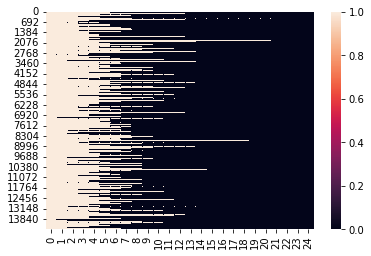

In [ ]:
import seaborn as sns
sns.heatmap((pd.DataFrame(super_train)>0).astype(int))

per caricare i dati, vai qua: [link](https://iaml.it/blog/multitask-learning-tensorflow)

In [ ]:
#train_tf = tf.data.Dataset.from_tensor_slices((super_train,super_y[1].values,super_y[0].values)) #da portare giù

In [ ]:
def input_fn(data, is_eval=False):

  # Path delle immagini
  filenames = tf.constant(data.iloc[:, 0].tolist())

  # Etichette delle immagini
  labels = tf.constant(data.iloc[:, 1:].values.astype(np.float32))

  # Costruisco il dataset
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  #dataset = dataset.map(_parse_function)

  # Logica di training / testing
  if is_eval:
    dataset = dataset.batch(64)
  else:
    dataset = dataset.repeat().shuffle(1000).batch(64)

  # Costruisco l'iteratore
  return dataset.make_one_shot_iterator().get_next()
def multihead_input_fn(data, is_eval=True):
  features, labels = input_fn(data, is_eval=is_eval)
  return features, {'head_nose': labels[:, 2:8:5], 'head_pose': tf.cast(labels[:, -1] - 1.0, tf.int32)}

In [ ]:
tf.constant(super_train)

<tf.Tensor: shape=(14514, 25), dtype=int32, numpy=
array([[   5,    4,    2, ...,    0,    0,    0],
       [  14,  258,    8, ...,    0,    0,    0],
       [  16, 2001,   41, ...,    0,    0,    0],
       ...,
       [  26,   17,   27, ...,    0,    0,    0],
       [  82,  337,   55, ...,    0,    0,    0],
       [  44,   12,  163, ...,    0,    0,    0]], dtype=int32)>

In [ ]:
tf.concat([super_y[1],super_y[0]],axis = -1)

<tf.Tensor: shape=(14514, 64), dtype=uint8, numpy=
array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>

In [ ]:
tokenizer = train_test['tokenizer']

In [ ]:
len(tokenizer.word_index)

6556

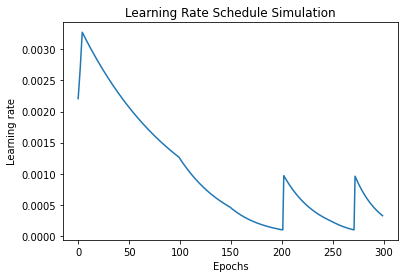

None

In [ ]:
#grumodel = GruModel()
grumodel = GruModel_orig()
#model = grumodel.gru_model(input_shape = train_test['train_set'][0].shape[1],voc_len = train_test['tokenizer'].num_words+1,rec_n_neurons=125,n_classes_int=train_test['train_set'][1][0]['intent'].unique().shape[0],n_classes_scen=train_test['train_set'][1][1]['scenario'].unique().shape[0],emb_neurons=64)
model = grumodel.gru_model(input_shape = train_test['train_set'][0].shape[1],voc_len = train_test['tokenizer'].num_words+1,n_classes_int=train_test['train_set'][1][0].shape[1],n_classes_scen=train_test['train_set'][1][1].shape[1],emb_neurons=128)
display(grumodel.schedule_plotter(0.002))

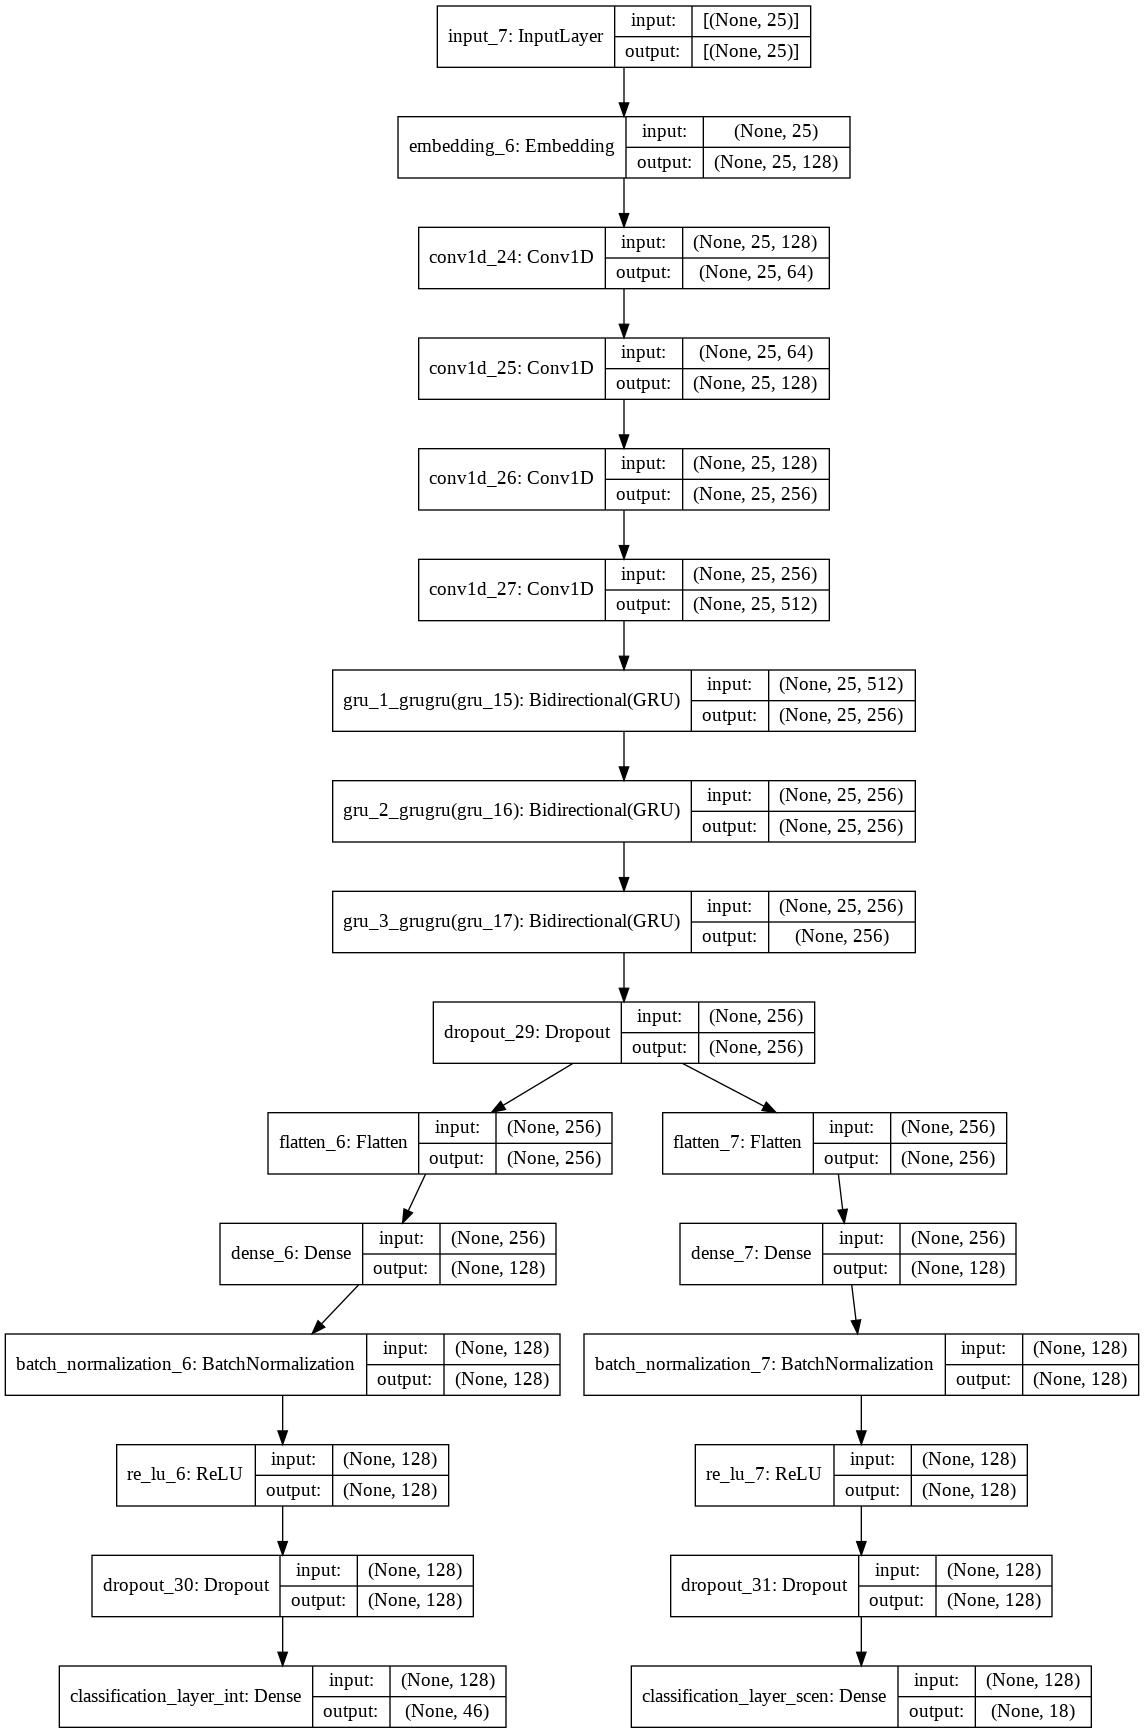

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
model.summary()

Model: "gru_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 25, 128)      839168      input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 25, 64)       41024       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 25, 128)      41088       conv1d_24[0][0]                  
__________________________________________________________________________________________

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0022071516, shape=(), dtype=float32).
103/103 [==============================] - 15s 56ms/step - loss: 6.5788 - classification_layer_int_loss: 2.5223 - classification_layer_scen_loss: 2.1191 - classification_layer_int_accuracy: 0.3508 - classification_layer_scen_accuracy: 0.3441 - val_loss: 3.8830 - val_classification_layer_int_loss: 2.0955 - val_classification_layer_scen_loss: 1.6849 - val_classification_layer_int_accuracy: 0.4787 - val_classification_layer_scen_accuracy: 0.4800
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.002435759, shape=(), dtype=float32).
103/103 [==============================] - 3s 32ms/step - loss: 3.1017 - classification_layer_int_loss: 1.6820 - classification_layer_scen_loss: 1.3173 - classification_layer_int_accuracy: 0.5146 - classification_layer_scen_accuracy: 0.5785 - val_loss: 3.5670 - val_classification_layer_int_loss: 1.9517 - va

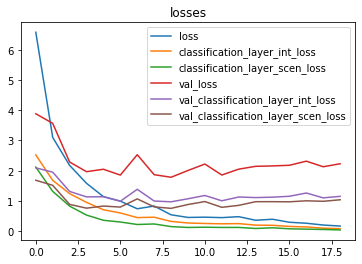

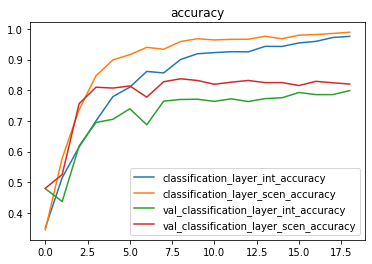

In [ ]:
beta1 = 0.9
beta2 = 0.999

callb = [History(),EarlyStopping(patience=10,min_delta=0.001,restore_best_weights=True,monitor='val_loss'),LearningRateScheduler(grumodel.scheduler,verbose=True)]
############# Compile if with one hot
#model.compile(optimizer=Adam(learning_rate=0.002,decay=1e-10,beta_1=beta1,beta_2=beta2),loss='categorical_crossentropy',metrics=['accuracy']) # Adam(learning_rate=0.002,decay=1e-10,beta_1=beta1,beta_2=beta2)
############# Compile if with sparse
model.compile(optimizer=Adam(learning_rate=0.002,decay=1e-10,beta_1=beta1,beta_2=beta2,amsgrad=True),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy']) # Adam(learning_rate=0.002,decay=1e-10,beta_1=beta1,beta_2=beta2)
#train_data = model.fit(train_test['train_set'][0],train_test['train_set'][1],epochs=300,validation_data=(train_test['test_set'][0],train_test['test_set'][1]),batch_size = 32,callbacks=callb,use_multiprocessing=True)
############################################
#train_tf = train_tf.shuffle(len(super_train)).batch(32)
#train_data = model.fit(train_tf,epochs=100,callbacks=callb) #batch_size = 16, validation_split=0.1,
train_data = model.fit(super_train,super_y,epochs=100,batch_size = 128, validation_split=0.1,callbacks=callb) #

tr_df = pd.DataFrame(train_data.history)
display(tr_df[['loss','classification_layer_int_loss','classification_layer_scen_loss','val_loss','val_classification_layer_int_loss','val_classification_layer_scen_loss']].plot(title='losses'))
display(tr_df[['classification_layer_int_accuracy','classification_layer_scen_accuracy','val_classification_layer_int_accuracy','val_classification_layer_scen_accuracy']].plot(title='accuracy'))

In [ ]:
model.layers[1].shape

AttributeError: ignored

In [ ]:
tr_df_old = pd.read_csv("./drive/My Drive/indra_challenge/model_data_training_multiple_elements.csv")
l = []
x = []
l_m = []
v_l_m = []
for k in tr_df_old.beta1.unique():
    for c in tr_df_old.beta2.unique():
        print("beta1 = {} | beta2 = {} | min loss = {} | min val_loss = {}".format(k,c,tr_df_old.loc[(tr_df_old.beta1==k) & (tr_df_old.beta2==c),"loss"].min(),tr_df_old.loc[(tr_df_old.beta1==k) & (tr_df_old.beta2==c),"val_loss"].min()))
        l.append(k)
        x.append(c)
        l_m.append(tr_df_old.loc[(tr_df_old.beta1==k) & (tr_df_old.beta2==c),"loss"].min())
        v_l_m.append(tr_df_old.loc[(tr_df_old.beta1==k) & (tr_df_old.beta2==c),"val_loss"].min())

pd.DataFrame({'beta1':l,'beta2':x,'loss_min':l_m,'val_loss_min':v_l_m})

beta1 = 0.91 | beta2 = 0.9995 | min loss = 0.007211541291326284 | min val_loss = 1.9128093719482424
beta1 = 0.91 | beta2 = 0.9998 | min loss = 0.00788529310375452 | min val_loss = 1.883827447891236
beta1 = 0.91 | beta2 = 0.998 | min loss = 0.0060071442276239395 | min val_loss = 2.09229588508606
beta1 = 0.91 | beta2 = 0.99985 | min loss = 0.009459915570914744 | min val_loss = 1.934241771697998
beta1 = 0.91 | beta2 = 0.9985 | min loss = 0.04674873873591423 | min val_loss = 2.0255448818206787
beta1 = 0.91 | beta2 = 0.99285 | min loss = nan | min val_loss = nan
beta1 = 0.915 | beta2 = 0.9995 | min loss = 0.012305879034101965 | min val_loss = 2.056542158126831
beta1 = 0.915 | beta2 = 0.9998 | min loss = 0.009579098783433436 | min val_loss = 1.9029687643051147
beta1 = 0.915 | beta2 = 0.998 | min loss = 0.005595457274466753 | min val_loss = 1.9440299272537231
beta1 = 0.915 | beta2 = 0.99985 | min loss = 0.007625427562743425 | min val_loss = 1.8682600259780884
beta1 = 0.915 | beta2 = 0.9985 | 

,beta1,beta2,loss_min,val_loss_min
0,0.910,0.99950,0.007212,1.912809
1,0.910,0.99980,0.007885,1.883827
2,0.910,0.99800,0.006007,2.092296
3,0.910,0.99985,0.009460,1.934242
4,0.910,0.99850,0.046749,2.025545
5,0.910,0.99285,NaN,NaN
6,0.915,0.99950,0.012306,2.056542
7,0.915,0.99980,0.009579,1.902969
8,0.915,0.99800,0.005595,1.944030
9,0.915,0.99985,0.007625,1.868260


In [ ]:
tr_df['beta1'] = beta1
tr_df['beta2'] = beta2

tr_df_old = pd.concat([tr_df_old,tr_df])
tr_df_old.to_csv("./drive/My Drive/indra_challenge/model_data_training_multiple_elements.csv")
l = []
x = []
l_m = []
v_l_m = []

for k in tr_df_old.beta1.unique():
    for c in tr_df_old.beta2.unique():
        print("beta1 = {} | beta2 = {} | min loss = {} | min val_loss = {}".format(k,c,tr_df_old.loc[(tr_df_old.beta1==k) & (tr_df_old.beta2==c),"loss"].min(),tr_df_old.loc[(tr_df_old.beta1==k) & (tr_df_old.beta2==c),"val_loss"].min()))
        l.append(k)
        x.append(c)
        l_m.append(tr_df_old.loc[(tr_df_old.beta1==k) & (tr_df_old.beta2==c),"loss"].min())
        v_l_m.append(tr_df_old.loc[(tr_df_old.beta1==k) & (tr_df_old.beta2==c),"val_loss"].min())

pd.DataFrame({'beta1':l,'beta2':x,'loss_min':l_m,'val_loss_min':v_l_m})

beta1 = 0.91 | beta2 = 0.9995 | min loss = 0.007211541291326284 | min val_loss = 1.9128093719482424
beta1 = 0.91 | beta2 = 0.9998 | min loss = 0.00788529310375452 | min val_loss = 1.883827447891236
beta1 = 0.91 | beta2 = 0.998 | min loss = 0.0060071442276239395 | min val_loss = 2.09229588508606
beta1 = 0.91 | beta2 = 0.99985 | min loss = 0.009459915570914744 | min val_loss = 1.934241771697998
beta1 = 0.91 | beta2 = 0.9985 | min loss = 0.04674873873591423 | min val_loss = 2.0255448818206787
beta1 = 0.91 | beta2 = 0.99285 | min loss = nan | min val_loss = nan
beta1 = 0.915 | beta2 = 0.9995 | min loss = 0.012305879034101965 | min val_loss = 2.056542158126831
beta1 = 0.915 | beta2 = 0.9998 | min loss = 0.009579098783433436 | min val_loss = 1.9029687643051147
beta1 = 0.915 | beta2 = 0.998 | min loss = 0.005595457274466753 | min val_loss = 1.9440299272537231
beta1 = 0.915 | beta2 = 0.99985 | min loss = 0.007625427562743425 | min val_loss = 1.8682600259780884
beta1 = 0.915 | beta2 = 0.9985 | 

,beta1,beta2,loss_min,val_loss_min
0,0.910,0.99950,0.007212,1.912809
1,0.910,0.99980,0.007885,1.883827
2,0.910,0.99800,0.006007,2.092296
3,0.910,0.99985,0.009460,1.934242
4,0.910,0.99850,0.046749,2.025545
5,0.910,0.99285,NaN,NaN
6,0.915,0.99950,0.012306,2.056542
7,0.915,0.99980,0.009579,1.902969
8,0.915,0.99800,0.005595,1.944030
9,0.915,0.99985,0.007625,1.868260


In [ ]:
model.summary()

Model: "gru_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 51)]         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 51, 64)       419584      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_75 (Dropout)            (None, 51, 64)       0           embedding_13[0][0]               
__________________________________________________________________________________________________
conv1d_36 (Conv1D)              (None, 51, 8)        3592        dropout_75[0][0]                 
__________________________________________________________________________________________

### Esempio:

Di seguito si propone un esempio del chatbot. Dipende da come si porta avanti il processo di training.

In [ ]:
q_n = 33
print("Question: ",data_all.loc[q_n,'question'])
data_all.loc[q_n,'question']
onehotted = one_hot(re.sub('\s{2,}', ' ', re.sub('([.,!?()\'])', r' \1 ', data_all.loc[q_n,'question'].lower().strip())),elements1.voc_len,filters='')

Question:  good morning


In [ ]:
prediction = model.predict(pad_sequences([onehotted],elements1.pad_max_len, padding='post')) 
print("Confidence is: %f for intent and %f for scenery"%(prediction[0].max(),prediction[1].max()))
print("Scenery is: ",train_test['train_set'][1][1].columns[prediction[1].argmax()].replace("scen_",""))
print("Intent is: ",train_test['train_set'][1][0].columns[prediction[0].argmax()].replace("int_",""))

Confidence is: 0.453207 for intent and 0.600452 for scenery
Scenery is:  [[START_CHAT]]
Intent is:  ciao


Confrontiamo i risultati di accuracy con i valori contenuti in scenario ed intent:

In [ ]:
train.scenario.value_counts()

calendar          2094
play              1822
qa                1656
email             1230
iot                927
general            842
weather            739
transport          724
lists              690
news               592
datetime           502
social             499
recommendation     482
alarm              432
music              412
takeaway           295
cooking            291
audio              285
Name: scenario, dtype: int64

In [ ]:
train.intent.value_counts()

query              4166
set                1213
music               841
quirky              740
factoid             736
remove              689
sendemail           482
radio               385
post                379
definition          353
recipe              289
podcasts            265
currency            265
events              225
createoradd         206
stock               189
locations           179
hue_lightoff        172
audiobook           167
ticket              167
game                164
hue_lightchange     157
querycontact        155
likeness            143
traffic             140
order               139
coffee              139
taxi                129
cleaning            120
volume_mute         114
maths               113
volume_up           101
hue_lightup          99
hue_lightdim         88
joke                 85
movies               78
wemo_off             69
convert              68
addcontact           62
wemo_on              56
settings             56
volume_down     

In [ ]:
data_all.intent.value_counts()

MTM                                             13
apertura_ticket                                 10
ciao                                            10
guide_MTM                                        9
cambio_valore_programmazione_settimanale_MRP     8
programmazione_settimanale_MRP                   7
enhancement_ultimo_mese                          6
anticipo_OSS                                     6
cosa_approvare                                   6
report_MTM                                       6
subPKOSS_1                                       5
ordini_su_OSS                                    1
programmazione_settimanale_MRP_valore            1
programmazione settimanale MRP                   1
apertura_ticket_modale                           1
Name: intent, dtype: int64

In [ ]:
data_all.scenario.value_counts()

[[START_CHAT]]               84
Create a new SubPK on OSS     5
Open ticket                   1
Name: scenario, dtype: int64

Com'è possibile notare, la numerosità degli intent per pattern è bassa in generale, con molti intent che presentano sì e no un solo pattern di riferimento. Questo può essere una delle cause dietro la scarsa confidenza presente per alcuni risultati.

Per tal motivo, si suggerisce un processo di **Data Augmentation** apposito.

### Error analysis

Dall'analisi degli errori risulta essere meglio usare un numero maggiore di patterns per singolo tag di minoranza, ovvero quello da noi utilizzato. Questo tipo di data generation si prefigge l'obiettivo di rendere il dataset error consistent ed, inotre, permetterebbe di avere una generalizzazione dei patterns durante tutto il processo di addestramento. Non solo, ma rendendo in generale il dataset consistente agli errori potremmo contare su una quantità di dati maggiore e, nonsolo, su uno stimatore che più difficilmente può sbagliare.

Da provare:

- SMOTE
- Generazione di dati da testi scritti

In [ ]:
train_test['train_set']

In [ ]:
model.layers

In [ ]:
plot_model(model,to_file='model_alt.png',show_shapes=True)

In [ ]:
files.download('model_alt.png')

In [ ]:
model.summary()

In [ ]:
#model.evaluate(trial['test_set'][0],trial['test_set'][1],callbacks=callb)

In [ ]:
question = "Requested product info"

In [ ]:
one_hot_pred = one_hot(question,49)

In [ ]:
el = data_preprocess_alt()

In [ ]:
pd.options.display.max_rows 

In [ ]:
#to calculate vocab length:
import seaborn as sns
voc_length = len(set([el for k in train.question.apply(el.normalize_sentence) for el in k.split()]))

In [ ]:
train.head()

In [ ]:
data, tokenizer = el.tokenize_and_filter(train.question.apply(el.normalize_sentence),voc_length)

In [ ]:
def evaluate(sentence,max_len):
    sentence = el.normalize_sentence(sentence)
    START_TOKEN, END_TOKEN = [tokenizer.vocab_size],[tokenizer.vocab_size+1]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    for i in range(max_len):
        predictions = model(inputs=[sentence], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence,voc_len):
    prediction = evaluate(sentence,voc_len)

    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [ ]:
train

In [ ]:
data

['hello',
 ',',
 'Greg',
 'be',
 'upstairs',
 'and',
 'want',
 'to',
 'be',
 'with',
 '-PRON-']

### To be worked: 

- We need to encode the text
- We need to make prediction from the encoded text
- Error from the predict method of the model.

# *Other Approaches*

In [ ]:
!wget http://www.cs.cmu.edu/~ark/QA-data/data/Question_Answer_Dataset_v1.2.tar.gz && tar -xvzf Question_Answer_Dataset_v1.2.tar.gz

--2020-12-07 08:43:42--  http://www.cs.cmu.edu/~ark/QA-data/data/Question_Answer_Dataset_v1.2.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8254496 (7.9M) [application/x-gzip]
Saving to: ‘Question_Answer_Dataset_v1.2.tar.gz’

Question_Answer_Dat 100%[===================>]   7.87M  2.37MB/s    in 3.4s    

2020-12-07 08:43:46 (2.30 MB/s) - ‘Question_Answer_Dataset_v1.2.tar.gz’ saved [8254496/8254496]

Question_Answer_Dataset_v1.2/
Question_Answer_Dataset_v1.2/S08/
Question_Answer_Dataset_v1.2/S08/question_answer_pairs.txt
Question_Answer_Dataset_v1.2/S08/data/
Question_Answer_Dataset_v1.2/S08/data/set4/
Question_Answer_Dataset_v1.2/S08/data/set4/a6.txt.clean
Question_Answer_Dataset_v1.2/S08/data/set4/a3.txt.clean
Question_Answer_Dataset_v1.2/S08/data/set4/a3.txt
Question_Answer_Dataset_v1.2/S08/data/set4/a5.txt
Question_Answer_Dataset_v1.2/

In [ ]:
!cd ./Question_Answer_Dataset_v1.2

In [ ]:
!ls -llah "./Question_Answer_Dataset_v1.2" 

total 48K
drwxr-xr-x 5 12174 users 4.0K Aug 23  2013 .
drwxr-xr-x 1 root  root  4.0K Dec  7 08:43 ..
-rw-r--r-- 1 12174 users  23K Nov  3  2008 LICENSE-S08,S09
-rwxr-xr-x 1 12174 users 2.8K Aug 23  2013 README.v1.2
drwxr-xr-x 3 12174 users 4.0K Aug  6  2010 S08
drwxr-xr-x 3 12174 users 4.0K Aug  6  2010 S09
drwxr-xr-x 3 12174 users 4.0K Aug  6  2010 S10


cat: 508: No such file or directory


# Kaggle dataset

an approach is here: [attention](https://www.kaggle.com/samsonleegh/chat-bot-word-based-with-attention)

In [ ]:
import json
token = {"username":"jenny1test","key":"bd70ce34724ba5feb06606ff161cabe4"}
with open('kaggle.json', 'w') as file:
    json.dump(token, file)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
import kaggle

In [ ]:
!kaggle datasets list -s Ticket

In [ ]:
!kaggle datasets download -d aniketg11/supportticketsclassification && unzip supportticketsclassification.zip

# Synonims

Here we illustrate synonims data driven approach. The dataset comes from WordNet from Princeton ([here](https://www.kaggle.com/duketemon/wordnet-synonyms?select=synonyms.json) the link).



In [ ]:
import numpy as np
array = np.array([1,2,3,4,5,6])

In [ ]:
array

array([1, 2, 3, 4, 5, 6])

In [ ]:
(array-6)*(-1)+1

array([6, 5, 4, 3, 2, 1])